<a href="https://colab.research.google.com/github/armandossrecife/my_validation/blob/main/My_Commits_and_my_Issues_from_Cassandra.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Análise de ATD do Repositório do Cassandra

Dada uma lista de **classes críticas** identificadas pelo método ATDCodeAnalyzer (https://github.com/mining-software-repositories/cassandra), checa se estas classes estão relacionadas a commits e issues com  architectural issues.

A validação será feita por meio de métodos de SATD nos commits e nos issues do repositório.

Logo abaixo seguem os passos da validação:

1. Instala dependências e bibliotecas para execução dos scripts

2. Funções e classes de apoio para análise de commits, issues e SATD

3. Clona o repositório para análise

4. Keywords de acordo com a literatura em SATD

5. Análise dos commits

6. Análise dos issues

7. Análise dos commits com SATD keywords e arquivos críticos e issues relacionados

8. Validação dos arquivos críticos junto aos issues selecionados

Obs: tempo de execução: ~2 horas

# Passos do experimento SATD em commits, issues com Classes Críticas (by ATDCodeAnalyzer)

Análise de SATD das mensagens e diffs de commits, bem como análise dos conteúdos de summary, description e comments de issues registrados em commits

1. Definir o conjunto de keywords da literatura

2. Fazer a análise de keywords para as mensagens dos commits e os diffs dos commits

2.1 Filtrar apenas os commits que possuam as classes críticas (by ATDCodeAnalyzer)

3. Fazer a análise de keywords para os issues que são registrados nos commits para os summary, description e comments

3.1 Filtrar apenas os issues com commits que possuam as classes críticas (by ATDCodeAnalyzer)

## My SATD Analyzer

Describe the steps to analyze commits and issues with SATD keywords

1. Identify Keywords for Self-Admitted Technical Debt (SATD):
Start by identifying keywords or phrases that commonly indicate self-admitted technical debt. These keywords can be derived from literature or based on your understanding of common terms used in code comments, commit messages, and issue descriptions. For example, common keywords may include "TODO," "FIXME," "refactor," "technical debt," "hack," "workaround," etc.

2. Create a Dictionary of SATD Keywords:
Build a dictionary or a set of SATD keywords that will serve as the basis for content queries in commit messages, modified file comments, and issue descriptions. This dictionary should include the keywords identified in Step 1.

3. Using PyDriller for Commit Analysis:
You can use PyDriller to analyze commits from the repository. PyDriller is a Python library for analyzing Git repositories. Install it using pip.
Create Python scripts that use PyDriller to iterate through the commits and identify those that contain SATD keywords in their messages. You can filter commits based on these keywords and store them in a Set.

4. Analyze Modified Files in Commits:
For each commit, extract the list of modified files. Open and analyze these files to check for SATD keywords in the code comments within the modified lines. Store the commits with modified files containing SATD in a separate Set.

5. Retrieve Issues from the Issue Tracker:
Utilize an API or libraries like JIRA's REST API to fetch issues from the issue tracker (JIRA in this case). For example, you can use Python's requests library to interact with the JIRA API. Query issues based on project (e.g., CASSANDRA) and extract the content of the Summary, Description, and Comments fields for each issue.

6. Analyze Issue Descriptions and Comments:
Analyze the content of the Summary, Description, and Comments fields for the presence of SATD keywords. Store the issues that contain these keywords in a Set.

7. Combine Results:
Combine the sets of commits and issues identified with SATD keywords from Steps 3, 4, and 6.

8. Display or Save Results:
You can choose to display the list of commits and issues with SATD keywords or save this information to a file or a database for further analysis.

9. Additional Preprocessing:
Depending on the quality of your results, you may need to perform additional preprocessing, such as removing false positives or refining the set of SATD keywords.

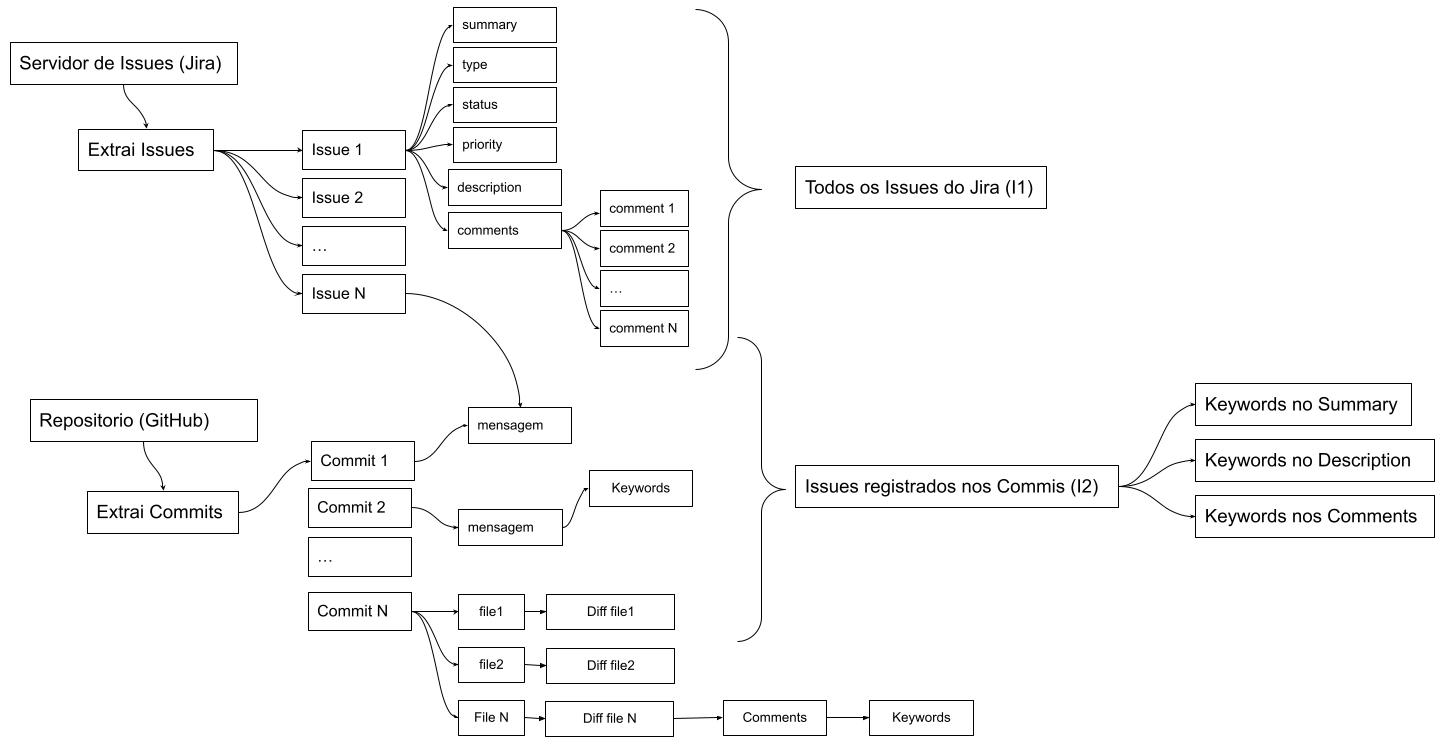

# 1. Install the dependencies

- Pydriller
- GitPython
- JiraPython
- SQLite

In [ ]:
print('Install Pydriller.')
!pip install pydriller > install_pydriller.log
print('Install gitpython.')
!pip3 install gitpython > install_gitpython.log
print('Install Jira Python lib.')
!pip install jira > install_jira_python.log
print('Install SQLite in Linux')
!sudo apt install -y sqlite3 > install_sqlite.log
print('All depenpencies installed!')
!cat *.log > install.log
print('Details in install.log')

Install Pydriller.
Install gitpython.
Install Jira Python lib.
Install SQLite in Linux


debconf: unable to initialize frontend: Dialog
debconf: (No usable dialog-like program is installed, so the dialog based frontend cannot be used. at /usr/share/perl5/Debconf/FrontEnd/Dialog.pm line 78, <> line 1.)
debconf: falling back to frontend: Readline
debconf: unable to initialize frontend: Readline
debconf: (This frontend requires a controlling tty.)
debconf: falling back to frontend: Teletype
dpkg-preconfigure: unable to re-open stdin: 
All depenpencies installed!
Details in install.log


# 2. Import dependencies, configurations, functions and supporting classes

In [ ]:
from pydriller import Repository
import tqdm
import os
import re

from jira import JIRA
from datetime import datetime, timedelta
import sqlite3
import subprocess

import collections
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import scipy.stats as stats

In [ ]:
url_to_repository = 'https://github.com/apache/cassandra.git'
path_to_repository = 'cassandra'
os.environ['MY_REPOSITORY'] = url_to_repository

JIRA_SERVER = 'https://issues.apache.org/jira'
DATABASE_NAME = "issues_db.db"

os.environ['DATABASE_NAME'] = DATABASE_NAME
# Credentials
os.environ['USERNAME'] = 'armandossrecife'
os.environ['PASSWORD'] = 'sky1979#ce'
username = os.environ.get('USERNAME')
password = os.environ.get('PASSWORD')

In [ ]:
class SATDCommitAnalyzer:
    def __init__(self, path_to_repository):
        self.path_to_repository = path_to_repository

    @staticmethod
    def is_java_comment(line):
        """Checks if a line is a single-line Java comment.

        Args:
          line: The line to check.

        Returns:
          True if the line is a single-line Java comment, False otherwise.
        """

        # Regular expression pattern to match Java comments
        comment_pattern = r'^\s*//|^\s*/\*|^\s*\*|^\s*\*/'

        # Use the re.match function to check if the line matches the comment pattern
        return bool(re.match(comment_pattern, line))

    def analyze_commits_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commits for SATD by checking if the commit message contains any of the specified SATD keywords.

        Args:
          start_date: The start date of the date range to analyze commits within.
          end_date: The end date of the date range to analyze commits within.
          satd_keywords: A list of SATD keywords to search for in commit messages.

        Returns:
          A tuple containing two sets:
            * A set of commit hashes that contain SATD keywords in their commit messages.
            * A dictionary mapping commit hashes to their associated commit messages.
        """
        # Initialize sets to store commits and their associated SATD keywords
        commits_with_satd = set()
        dict_commit_msg = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress messagem commit analysis"):
            for keyword in satd_keywords:
                if keyword in commit.msg:
                    commits_with_satd.add(commit.hash)
                    dict_commit_msg[commit.hash] = commit.msg

        return commits_with_satd, dict_commit_msg

    def analyze_commit_diffs_for_satd(self, start_date, end_date, satd_keywords):
        """Analyzes commit diffs for SATD by checking if any of the specified SATD keywords are found in any of the added lines of the diff.

        Args:
          start_date: The start date of the date range to analyze commit diffs within.
          end_date: The end date of the date range to analyze commit diffs within.
          satd_keywords: A list of SATD keywords to search for in commit diffs.

        Returns:
          A dictionary mapping commit hashes to lists of tuples, where each tuple contains a SATD keyword and the corresponding line of the diff where the keyword was found.
        """
        # Initialize a dictionary to store commit hashes and their associated SATD keywords and diff content
        dict_commit_diffs = {}

        # Traverse commits within the specified date range
        print('Aguarde...')
        my_traverser_commits = Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits()
        total_commits = len(list(my_traverser_commits))

        for commit in tqdm.tqdm(Repository(self.path_to_repository, since=start_date, to=end_date).traverse_commits(), total=total_commits, desc="Progress diff commit analysis"):
            list_keywords_by_commit = []
            list_diff_content_by_commit = []

            for modification in commit.modified_files:
                for line in modification.diff_parsed['added']:
                    valor_linha = line[0]
                    conteudo_linha = line[1]

                    for keyword in satd_keywords:
                        if SATDCommitAnalyzer.is_java_comment(conteudo_linha):
                            if keyword in conteudo_linha:
                                list_keywords_by_commit.append(keyword)
                                list_diff_content_by_commit.append(conteudo_linha)

            if list_keywords_by_commit:
                elemento = list_keywords_by_commit, list_diff_content_by_commit
                dict_commit_diffs[commit.hash] = elemento

        return dict_commit_diffs

In [ ]:
def get_commits_by_range_and_critical_files(initial_date, final_date, critical_files):
  """Extracts information from a date range of commits, focusing on critical files.
  Args:
      initial_date: inicial date of commits
      final_date: final date of commits
      critical_files: A list of critical file paths. ex: ['StorageService.java', 'ColumnFamilyStore.java']
  Returns:
        A dictionary of commits, where the keys are the commit hashes and the
        values are tuples containing the commit message, a list of critical files modified in the commit, a dictionary of diff [filename]:filename.diff, a list_of_modified_files, a list of all diffs from modified files
  """

  dict_commit_modified_files = {}
  print('Wait...')
  my_traverser_commits = Repository("cassandra", since=initial_date, to=final_date).traverse_commits()
  total_commits = len(list(my_traverser_commits))
  try:
    for commit in tqdm.tqdm(Repository("cassandra", since=initial_date, to=final_date).traverse_commits(), total=total_commits, desc="Progress critical files commit anlysis"):
      list_of_critical_files_modified = []
      list_of_modified_files = []
      list_dict_of_diff_files = []
      list_dict_of_diff_modified_files = []
      for m in commit.modified_files:
        dict_diff_file = {}
        list_of_modified_files.append(m.filename)
        list_dict_of_diff_modified_files.append(m.diff)
        if m.filename in critical_files:
          list_of_critical_files_modified.append(m.filename)
          dict_diff_file[m.filename] = m.diff
          list_dict_of_diff_files.append(dict_diff_file)
      if len(list_of_critical_files_modified) > 0:
        data_commit = str(commit.committer_date.day) + '/' + str(commit.committer_date.month) + '/' + str(commit.committer_date.year)
        element = commit.msg, list_of_critical_files_modified, data_commit, commit.lines, commit.files, list_dict_of_diff_files, list_of_modified_files, list_dict_of_diff_modified_files
        dict_commit_modified_files[commit.hash] = element
  except Exception as ex:
    print(f'Erro during travesse commits: {str(ex)}')
  return dict_commit_modified_files, total_commits

In [ ]:
class JiraIssue:
  def __init__(self, key, summary, issue_type, status, priority, description, comments):
    self.key = key
    self.summary = summary
    self.issue_type = issue_type
    self.status = status
    self.priority = priority
    self.description = description
    self.comments = comments

  def get_comments(self):
    return self.comments

  def __str__(self):
    return (f'Key: {self.key}, Summary: {self.summary}, Type: {self.issue_type}, Status: {self.status}')

class JiraIssues:
  def __init__(self,project, issues):
    self.project = project
    self.issues = issues

  def add_issue(self, issue):
    self.issues.append(issue)

  def get_issues(self) -> list:
    return self.issues

  def update_issues(self, issues):
    self.issues = issues

  def __str__(self):
    str_issues = ""
    for issue in self.get_issues():
      str_issues = str_issues + str(issue)
      str_issues = str_issues + ', '
    str_issues = '[' + str_issues + ']'
    return (f'Project: {self.project}, Qdt of issues: {len(self.issues)}, Issues: {str_issues}')

# Classe de utilidades para manipular o servidor Jira
class JiraUtils:
  def __init__(self, project, jira_instance):
    self.project = project
    self.jira_jira_instance = jira_instance

  def generate_intervals_between_dates(self, date1: tuple, date2: tuple, distance=120) -> list:
    start_date = datetime(date1[0], date1[1], date1[2])
    end_date = datetime(date2[0], date2[1], date2[2])
    interval_days = distance
    # Initialize a list to store the intervals
    intervals = []
    # Initialize the current date as the start date
    current_date = start_date
    # Loop to generate intervals until the current date is less than or equal to the end date
    while current_date < end_date:
        interval = (current_date, current_date + timedelta(days=interval_days - 1))
        intervals.append(interval)
        current_date += timedelta(days=interval_days)
    return intervals

  def convert_interval_dates(self, dates: list) -> list:
    list_interval_dates = []
    for each in dates:
      date1 = each[0]
      # Convert the date to a string in the format "YYYY/MM/DD".
      str_date1 = date1.strftime("%Y/%m/%d")
      date2 = each[1]
      str_date2 = date2.strftime("%Y/%m/%d")
      elemento = str_date1, str_date2
      list_interval_dates.append(elemento)
    return list_interval_dates

  def generate_list_of_sentences(self, dates: list) -> list:
    lista_sentencas = []
    for each in dates:
      str_date1 = each[0].strftime("%Y/%m/%d")
      str_date2 = each[1].strftime("%Y/%m/%d")
      sentenca = f'project={self.project.upper()} and created>="{str_date1}" and created<="{str_date2}"'
      lista_sentencas.append(sentenca)
    return lista_sentencas

  def get_list_of_block_issues_by_dates(self,date1, date2, distance=120) -> list:
    print('Aguarde...')
    t1 = datetime.now()
    list_of_dates = self.generate_intervals_between_dates(date1,date2,distance)
    lista_sentencas = self.generate_list_of_sentences(list_of_dates)
    lista_bloco_issues_by_date = []
    total_items = len(lista_sentencas)
    i = 0
    iterable_lista_sentencas = tqdm.tqdm(lista_sentencas, total=total_items)
    for each in iterable_lista_sentencas:
      issues_by_date_temp = self.jira_jira_instance.search_issues(each,maxResults=1000)
      print(f'Range: {each}, qtd issues: {len(issues_by_date_temp)}')
      lista_bloco_issues_by_date.append(issues_by_date_temp)
      percentage = (i + 1) / total_items * 100
      iterable_lista_sentencas.set_description(f"Progress Message Analysis")
    i += 1
    t2 = datetime.now()
    print(t2)
    print(f'Tempo da consulta: {t2-t1}')
    return lista_bloco_issues_by_date

  def concatenate_block_of_issues(self,block_of_issues):
    concatenated_list = [item for sublist in block_of_issues for item in sublist]
    print(f'Total de issues recuperados: {len(concatenated_list)}')
    return concatenated_list

class IssuesDatabase:
    def __init__(self, database_name):
        self.database_name = database_name
        self.create_tables()

    def create_tables(self):
        self.conn = sqlite3.connect(self.database_name)
        self.cursor = self.conn.cursor()

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Issues (
                id INTEGER PRIMARY KEY,
                project TEXT,
                key TEXT,
                summary TEXT,
                issue_type TEXT,
                status TEXT,
                priority TEXT,
                description TEXT
            )
        ''')

        self.cursor.execute('''
            CREATE TABLE IF NOT EXISTS Comments (
                id INTEGER PRIMARY KEY,
                key TEXT,
                comment TEXT
            )
        ''')

        self.conn.commit()

    def insert_in_table_issues(self, project, key, summary, issue_type, status, priority, description):
        values = (None, project, key, summary, issue_type, status, priority, description)
        self.cursor.execute('''
            INSERT INTO Issues
            (id, project, key, summary, issue_type, status, priority, description)
            VALUES (?, ?, ?, ?, ?, ?, ?, ?)
        ''', values)

        self.conn.commit()

    def insert_in_table_comments(self, key, comment):
        values = (None, key, comment)
        self.cursor.execute('''
            INSERT INTO Comments
            (id, key, comment)
            VALUES (?, ?, ?)
        ''', values)

        self.conn.commit()

    def show_content(self, table):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()
        for row in rows:
            print(row)

    def show_n_lines(self, table, n):
        query = f"SELECT * FROM {table}"
        self.cursor.execute(query)

        rows = self.cursor.fetchall()

        for i, row in enumerate(rows):
            print(row)
            if i == n:
              break

    def close_connection(self):
        self.conn.close()

def analyze_jira_issues_for_satd(project, satd_keywords, all_issues):
    # Create an instance of JiraIssues to manage SATD issues
    satd_issues = JiraIssues(project, [])

    total_items = len(all_issues)

    # Iterate through the fetched issues
    for issue in tqdm.tqdm(all_issues, total=total_items, desc='Progress jira issues analysis'):
        issue_key = issue.key
        issue_summary = issue.fields.summary
        issue_description = issue.fields.description
        issue_comments = [comment.body for comment in issue.fields.comment.comments]

        # Check for SATD keywords in the issue's summary, description, and comments
        if issue_summary is None:
            issue_summary = ""
        if issue_description is None:
            issue_description = ""
        if issue_comments is None:
            issue_comments = ""

        is_satd = any(keyword in (issue_summary + issue_description + ' '.join(issue_comments)) for keyword in satd_keywords)

        if is_satd:
            issue_type = issue.fields.issuetype.name
            issue_status = issue.fields.status.name
            issue_priority = issue.fields.priority.name

            # Create a JiraIssue instance for the SATD issue
            satd_issue = JiraIssue(issue_key, issue_summary, issue_type, issue_status, issue_priority, issue_description, issue_comments)

            # Add the SATD issue to the list of SATD issues
            satd_issues.add_issue(satd_issue)

    return satd_issues

In [ ]:
def show_pie(my_df, my_field, my_title):
  type_counts = my_df[my_field].value_counts().sort_values(ascending=False)
  type_percentages = type_counts / type_counts.sum() * 100

  plt.pie(type_percentages, labels=type_counts.index, autopct="%.1f%%")
  plt.title(my_title)
  plt.show()

def get_max_n_chars(text, max_n):
  """Returns the maximum n characters of the text.

  Args:
    text: A string containing the text.

  Returns:
    A string containing the maximum n characters of the text.
  """

  text_length = len(text)
  if text_length <= max_n:
    return text
  else:
    return text[:max_n]

def create_new_file(filename, dir_name, issue_type, summary, description, status, comments):
  try:
    print('Creating a new text file...')
    print(f'Create file {filename} in {dir_name}')
    filename = dir_name + '/' + filename

    if issue_type is None:
      issue_type = ''
    if summary is None:
      summary = ''
    if description is None:
      description = ''
    if status is None:
      status = ''
    if comments is None:
      comments = ''

    with open(filename, mode='w') as f_issue:
      f_issue.write(f'issue_type: {issue_type} \n')
      f_issue.write(f'summary: {summary} \n')
      f_issue.write(f'description: {get_max_n_chars(text=description, max_n=1000)} \n')
      f_issue.write(f'status: {status} \n')
      f_issue.write(f'comments: {get_max_n_chars(text=comments, max_n=4000)} \n')
    print(f'File {filename} created with success!')

  except Exception as ex:
    print(f'Erro: {str(ex)}')

def calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size):
    # Calculate the Z-score for the given confidence level
    z_score = stats.norm.ppf(1 - (1 - confidence_level) / 2)

    # Calculate the sample size formula
    sample_size = ((z_score**2) * population_proportion * (1 - population_proportion)) / (margin_of_error**2)

    # Adjust for finite population
    if population_size:
        sample_size = sample_size / (1 + ((sample_size - 1) / population_size))

    return int(sample_size)

# 3. Cloning the local repository

In [ ]:
print(f'Clona o repositório : {url_to_repository}')
!git clone $MY_REPOSITORY

Clona o repositório : https://github.com/apache/cassandra.git
Cloning into 'cassandra'...
remote: Enumerating objects: 403330, done.
remote: Counting objects: 100% (6110/6110), done.
remote: Compressing objects: 100% (2181/2181), done.
remote: Total 403330 (delta 2930), reused 5713 (delta 2810), pack-reused 397220
Receiving objects: 100% (403330/403330), 399.65 MiB | 26.05 MiB/s, done.
Resolving deltas: 100% (234829/234829), done.
Updating files: 100% (6130/6130), done.


In [ ]:
!cd cassandra && git log --pretty="%H %s" > all_commits_msg.txt
!cd cassandra && git log --pretty="%H;%ai;%s" > all_commits_full.txt

# Dados do 1o commit e do ultimo commit
!echo "Último commit: "
!head /content/cassandra/all_commits_full.txt -n 1
!echo "Primeiro commit: "
!tail /content/cassandra/all_commits_full.txt -n 1

Último commit: 
865d7c30e4755e74c4e4d26205a7aed4cfb55710;2023-10-06 11:52:56 +0200;Merge branch 'cassandra-5.0' into trunk
Primeiro commit: 
1f91e99223b0d1b7ed8390400d4a06ac08e4aa85;2009-03-02 07:57:22 +0000;git-svn-id: https://svn.apache.org/repos/asf/incubator/cassandra/trunk@749218 13f79535-47bb-0310-9956-ffa450edef68


# 4. Keywords about SATD (Self-admitted Technical Debt)

Self-Admitted Technical Debt (SATD) refers to situations where the developers are aware that the current implementation is not optimal and write comments alerting of the problems [3]

[1] Rantala, Leevi, and Mika Mäntylä. "Predicting technical debt from commit contents: reproduction and extension with automated feature selection." Software Quality Journal 28 (2020): 1551-1579. ~> https://link.springer.com/article/10.1007/s11219-020-09520-3

[2] Li, Yikun, Mohamed Soliman, and Paris Avgeriou. "Automatic identification of self-admitted technical debt from four different sources." Empirical Software Engineering 28, no. 3 (2023): 1-38. ~> https://link.springer.com/article/10.1007/s10664-023-10297-9

[3] Potdar, Aniket, and Emad Shihab. "An exploratory study on self-admitted technical debt." In 2014 IEEE International Conference on Software Maintenance and Evolution, pp. 91-100. IEEE, 2014. ~> https://ieeexplore.ieee.org/abstract/document/6976075

In [ ]:
satd_keywords_1_2 = {
    "typo", "unused import", "error message", "comment", "logging", "javadoc", "minor", "update",
    "debug", "code cleanup", "formatting", "more tests", "documentation", "work in progress",
    "improvement", "rename", "support for", "header", "interface", "annotation", "naming",
    "tidy up", "files", "extension point", "exception", "handling", "test", "output", "cast",
    "simplify", "findbugs", "leak", "implementation", "unused code", "API", "refactoring",
    "checkstyle errors", "redundant", "deprecated code", "constructor", "endpoints", "flaky",
    "unused", "unnecessary", "confusing", "ugly", "simplify", "too much", "not used", "more readable",
    "more efficient", "dead code", "infinite loop", "too long", "not implemented", "less verbose",
    "more robust", "speed up", "get rid of", "not thread safe", "clean up code", "not done yet",
    "avoid extra seek", "reduce duplicate code", "no longer needed", "not supported yet",
    "documentation doesn't match", "short term solution", "spurious error messages", "it'd be nice",
    "please add a test", "would significantly improve", "performance", "makes it much easier",
    "avoid calling it twice", "takes a long time", "good to have coverage",
    "makes it very hard", "patch doesn't apply cleanly", "it's not perfectly documented",
    "need to update documentation", "make it less brittle", "documentation does not mention",
    "wastes a lot of space", "there is no unit test", "lead to huge memory allocation",
    "test doesn't add much value", "some holes in the doc", "by hard coding instead of",
    "should be updated to reflect", "more tightly coupled than ideal", "any chance of a test",
    "should improve a bit by", "solution won't be really satisfactory", "misleading",
    "too long", "please add a test", "there is no unit test", "any chance of a test",
    "good to have coverage", "test doesn't add much value", "flaky",
}

satd_keywords_diff_3 = {'TODO', 'FIXME', 'refactor', 'refact', 'hack', 'workaround', 'technical debt', 'cleanup', 'clean', 'fix'}

# Extra keywords
extra_keywords = set([
    "architectural issue", "architectural smell", "architectural debt", "design debt", "code rot", "spaghetti code",
    "quick fix", "temporary solution", "workaround", "hack", "technical kludge", "inconsistency", "race condition", "performance",
    "scalability", "reliability", "maintainability", "code duplication", "code complexity", "tight coupling", "fragile code",
    "magic numbers", "magic strings", "lack of modularity", "lack of encapsulation", "lack of abstraction", "lack of documentation",
    "lack of testing", "complexity", "duplication", "modularity", "encapsulation", "design", "violation", "dependency",
    "dependencies", "refactoring", "cyclic dependency", "unstable", "cross-module",
    "code smell", "architectural problem", "design issue", "system design problem",
    "technical debt due to architectural issues", "code debt", "technical debt due to design issues", "design flaws",
    "disorganized code", "difficult to maintain code", "poorly structured code", "complex code",
    "concurrency issue", "multithreading issue", "synchronization issue",
    "speed", "throughput", "latency", "response time",
    "scalability issue", "ability to handle increased load",
    "dependability", "trustworthiness", "fault tolerance", "robustness",
    "ease of maintenance", "maintainability issue", "ability to evolve",
    "code redundancy", "repeated code",
    "code difficulty", "complex code", "difficult to understand code",
    "code entanglement", "code interdependencies", "complex code relationships",
    "delicate code", "brittle code", "easy to break code",
    "literal values", "hard-coded values", "undocumented values",
    "literal strings", "hard-coded strings", "undocumented strings",
    "monolithic code", "lack of separation of concerns", "lack of cohesion",
    "exposed internal state", "lack of information hiding",
    "concrete code", "lack of generalization",
    "undocumented code", "poorly documented code", "lack of code comments",
    "untested code", "poorly tested code", "lack of test cases",
    "code complexity", "cyclomatic complexity", "cognitive complexity",
    "code dependencies", "module dependencies", "system dependencies",
    "code restructuring", "code improvement", "code simplification",
    "circular dependency", "indirect dependency",
    "buggy code", "flaky code", "unreliable code",
    "inter-module", "module-to-module"
])

extra_keywords_td = set([
    "anti-pattern", "bad practice", "code smell", "design smell", "technical debt",
    "wrong solution", "poor solution", "ineffective solution", "inefficient solution", "suboptimal solution",
    "wrong way", "poor way", "ineffective way", "inefficient way", "suboptimal way",
    "code defect", "code problem", "code issue", "code flaw",
    "design defect", "design problem", "design issue", "design flaw",
    "code debt", "design debt", "architectural debt", "implementation debt", "testing debt", "documentation debt"
])

my_satd_keywords = satd_keywords_diff_3.union(satd_keywords_1_2)

my_satd_aux = my_satd_keywords.union(extra_keywords)

final_satd_keywords = my_satd_aux.union(extra_keywords_td)

# Sort the set of strings in ascending order.
sorted_my_satd_keywords = sorted(final_satd_keywords)

print(f'Qtd de sorted_my_satd_keywords: {len(sorted_my_satd_keywords)}')
# Print the sorted set of strings.
for word in sorted_my_satd_keywords:
  print(word)

Qtd de sorted_my_satd_keywords: 235
API
FIXME
TODO
ability to evolve
ability to handle increased load
annotation
anti-pattern
any chance of a test
architectural debt
architectural issue
architectural problem
architectural smell
avoid calling it twice
avoid extra seek
bad practice
brittle code
buggy code
by hard coding instead of
cast
checkstyle errors
circular dependency
clean
clean up code
cleanup
code cleanup
code complexity
code debt
code defect
code dependencies
code difficulty
code duplication
code entanglement
code flaw
code improvement
code interdependencies
code issue
code problem
code redundancy
code restructuring
code rot
code simplification
code smell
cognitive complexity
comment
complex code
complex code relationships
complexity
concrete code
concurrency issue
confusing
constructor
cross-module
cyclic dependency
cyclomatic complexity
dead code
debug
delicate code
dependability
dependencies
dependency
deprecated code
design
design debt
design defect
design flaw
design flaws


# 5. Analyze commits

Analisa todas as mensagens e diffs dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que contem as Keywords coletadas da literatura.

## 5.1 Analyzes commit messages

Analisa todas as mensagens dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que contem as Keywords coletadas da literatura.

In [ ]:
start_date = datetime(2009, 3, 2, 0, 0, 0)
end_date = datetime(2023, 10, 4, 0, 0, 0)

my_satd_commit_analyzer = SATDCommitAnalyzer(path_to_repository)
commits_with_satd, dict_commit_msg = my_satd_commit_analyzer.analyze_commits_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress messagem commit analysis: 100%|██████████| 29230/29230 [00:10<00:00, 2830.47it/s]


## 5.2 Analyzes commit diffs

Analisa todos os diffs (added) dos commits entre 2/03/2009 e 4/10/2023 do Cassandra que contem as Keywords coletadas da literatura + outros termos relacionados a problemas estruturais (arquitetura) de software ou architctural issues

In [ ]:
dict_commit_diffs = my_satd_commit_analyzer.analyze_commit_diffs_for_satd(start_date, end_date, final_satd_keywords)

Aguarde...


Progress diff commit analysis: 100%|██████████| 29230/29230 [20:50<00:00, 23.38it/s]


### 5.2.1 Cria um dataframe para representar o resultado da análise de SATD Keywords dos Diffs dos commits

In [ ]:
l_commits, l_keywords, l_comments = [], [], []

for k, v in dict_commit_diffs.items():
  l_commits.append(k)
  l_keywords.append(v[0])
  l_comments.append(v[1])

dict_commit_diffs_aux = {
    'commits': l_commits,
    'keywords': l_keywords,
    'comments': l_comments
}

df_commit_diffs_aux = pd.DataFrame(dict_commit_diffs_aux)

df_commit_diffs_aux.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4339 entries, 0 to 4338
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   commits   4339 non-null   object
 1   keywords  4339 non-null   object
 2   comments  4339 non-null   object
dtypes: object(3)
memory usage: 101.8+ KB


In [ ]:
df_commit_diffs_aux.head()

,commits,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,"[fix, exception, implementation, update, updat...",[\t * Throws an exception if the metrics imple...
1,82f5b6072a283d6742b7783e2d856c1d2c0e1f39,[API],[ // The following are beta APIs being introd...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
3,abc75388a3df8de72b28a5edb830e1c19ed9ec80,"[test, test]",[ /* inverse sort by time to get hte la...
4,def1edd1fe90a4a9c9eef4ef26f422ba3a21d28f,[TODO],[ // TODO shouldn't this be checked...


In [ ]:
list_commit_with_satd_keywords = df_commit_diffs_aux.commits.to_list()
print('Commits com SATD Keywords: ')
print(f'{len(list_commit_with_satd_keywords)}, {list_commit_with_satd_keywords}')

Commits com SATD Keywords: 
4339, ['1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', '82f5b6072a283d6742b7783e2d856c1d2c0e1f39', 'b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d', 'abc75388a3df8de72b28a5edb830e1c19ed9ec80', 'def1edd1fe90a4a9c9eef4ef26f422ba3a21d28f', '66dee7aaab26556561614ab056469ade85de5ebd', 'a996c8214baa4fa886071a24b8058ed1ca284686', '20e081f2901384f0786a56fb21a181033aa8e839', 'dd61d5119d951d94da28256e5482d580a0685030', 'bf684eea956dbbbf7a35ef3deca8b4462b139136', '4c194aa8d14cc8b473939d3496cd576c4cb397e7', 'f5d1a1289c88dcefd226e9ffcca2a1cd2d145892', '964dd9bb57230e1973aaede17c520ede1453a210', '52062900caf861e237355c297709976036c70404', '1cc4294d349e4d24c8a0894e3b4748d5f3798f00', 'bd884e4d986ebfa5568a431abc55813a6a903bb5', '3a6cbb128c613515930a99ce70c29903d26c9b36', '9049d5919dfcfca6a536caa9007172d01a2730b4', '21c1d6b9c7c72ed6d75cc0b3203a3c651ae3af6b', 'ecfe313d50e59e43edea8c12c60abf62838a3ffd', '7e648c89a0bbd059b9ca9b73e30e0f27549e535f', 'ce5e583b4b2d9fb64af55c9416e5ef1d412e742c

In [ ]:
print('Converte a lista de commits para um conjunto')
set_list_commit_with_satd_keywords = set(list_commit_with_satd_keywords)
len(set_list_commit_with_satd_keywords)

Converte a lista de commits para um conjunto


4339

## 5.3 Lista de Arquivos Críticos

Projeto Cassandra (https://github.com/apache/cassandra)

Lista de arquivos críticos do Cassandra impactados por ATD

Obs: extraídos via ATDCodeAnalyzer (https://github.com/mining-software-repositories/cassandra)

### Funções de apoio

In [ ]:
# Conta a quantidade de vezes que um arquivo critico apareceu na faixa de commits analisados
def get_dict_commits_count_by_critical_files(lista_arquivos_criticos, my_commits_to_analyse):
  dict_count_critical_files = {}
  for file in lista_arquivos_criticos:
    dict_count_critical_files[file] = 0

  for k, v in my_commits_to_analyse.items():
    message, critical_files, dict_of_diffs = v[0], v[1], v[2]
    for file in lista_arquivos_criticos:
      if file in critical_files:
        dict_count_critical_files[file] = dict_count_critical_files[file] + 1

  return dict_count_critical_files

def get_df_critical_files_in_commits(lista_arquivos_criticos, my_commits_to_analyse):
  """Prints the number of times each critical file appears in the commits.
  Args:
    lista_arquivos_criticos: A list of critical file names.
    my_commits_to_analyse: A list of commits to analyze.
  Returns:
    A Pandas DataFrame containing the number of times each critical file appears in the commits.
  """

  # Get the dictionary of commit counts for each critical file.
  dict_count_critical_files = get_dict_commits_count_by_critical_files(lista_arquivos_criticos, my_commits_to_analyse)

  # Create a list of file names and commit counts.
  list_name_files, list_qtd_commits = [], []
  for k, v in dict_count_critical_files.items():
    list_name_files.append(k)
    list_qtd_commits.append(v)

  # Create a dictionary of critical files and commit counts.
  dict_critical_files_in_commits = {
      'file': list_name_files,
      'appears_in_commits': list_qtd_commits
  }

  # Create a Pandas DataFrame from the dictionary.
  df_critical_files_in_commits = pd.DataFrame(dict_critical_files_in_commits)

  return df_critical_files_in_commits

def find_all_issues_cassandra(input_string: str) -> list[str]:
    """Finds all Cassandra issue ID patterns in the input string.
    Args:
        input_string: The input string.
    Returns:
        A list of Cassandra issue IDs, if found; otherwise, an empty list.
    """
    # Try to find all Cassandra issue ID patterns in the input string
    matches = re.findall(r'(CASSANDRA-\d+)', input_string)
    set_matches = set(matches)
    list_unique_matches = list(set_matches)

    # Return the list of matched Cassandra issue IDs
    return list_unique_matches

def get_dict_commits_with_issues(my_commits_to_analyse):
  dict_commits_with_issues = {}
  for k, v in my_commits_to_analyse.items():
    message, critcial_files, dict_of_diffs = v[0], v[1], v[2]
    if len(find_all_issues_cassandra(message)) > 0:
      dict_commits_with_issues[k] = v

  return dict_commits_with_issues

def get_df_critical_files_in_commits_with_issues(lista_arquivos_criticos, dict_commits_with_issues):
  """Prints the number of times each critical file appears in the commits with issues.
  Args:
    lista_arquivos_criticos: A list of critical file names.
    dict_commits_with_issues: A dictionary of commits with issues, where the keys are the commit hashes and the values are the lists of files changed in the commit.
  Returns:
    A Pandas DataFrame containing the number of times each critical file appears in the commits with issues.
  """

  # Get the dictionary of commit counts for each critical file.
  dict_count_critical_files_with_issues = get_dict_commits_count_by_critical_files(lista_arquivos_criticos, dict_commits_with_issues)

  # Create a list of file names and commit counts.
  list_name_files, list_qtd_commits = [], []
  for k, v in dict_count_critical_files_with_issues.items():
    list_name_files.append(k)
    list_qtd_commits.append(v)

  # Create a dictionary of critical files and commit counts.
  dict_critical_files_in_commits_with_issues = {
      'file': list_name_files,
      'appears_in_commits_with_issues': list_qtd_commits
  }

  # Create a Pandas DataFrame from the dictionary.
  df_critical_files_in_commits_with_issues = pd.DataFrame(dict_critical_files_in_commits_with_issues)


  return df_critical_files_in_commits_with_issues


### Relação de Arquivos Críticos

Lista de arquivos críticos extraídos do ATDCodeAnalyzer

In [ ]:
lista_arquivos_criticos = ['StorageService.java', 'ColumnFamilyStore.java','DatabaseDescriptor.java','CompactionManager.java','StorageProxy.java','SSTableReader.java','Config.java','CassandraDaemon.java','SelectStatement.java','SinglePartitionReadCommand.java','NodeProbe.java','MessagingService.java']
lista_arquivos_criticos

['StorageService.java',
 'ColumnFamilyStore.java',
 'DatabaseDescriptor.java',
 'CompactionManager.java',
 'StorageProxy.java',
 'SSTableReader.java',
 'Config.java',
 'CassandraDaemon.java',
 'SelectStatement.java',
 'SinglePartitionReadCommand.java',
 'NodeProbe.java',
 'MessagingService.java']

### Análise dos commits que contem Arquivos Críticos

- Filtra apenas os commits que contem pelo menos um arquivo crítico

In [ ]:
print(f'Analisa a faixa de commits entre: initial_date={str(start_date)}, final_date={str(end_date)}')
print('Registra apenas os commits que contem pelo menos um arquivo crítico')
commits_to_analyze = get_commits_by_range_and_critical_files(initial_date=start_date, final_date=end_date, critical_files=lista_arquivos_criticos)

Analisa a faixa de commits entre: initial_date=2009-03-02 00:00:00, final_date=2023-10-04 00:00:00
Registra apenas os commits que contem pelo menos um arquivo crítico
Wait...


Progress critical files commit anlysis: 100%|██████████| 29230/29230 [06:30<00:00, 74.79it/s]


Total de commits analisados: 29230
Commits que possuem pelo menos um arquivo crítico: 4522
Commits sem arquivos críticos: 24708




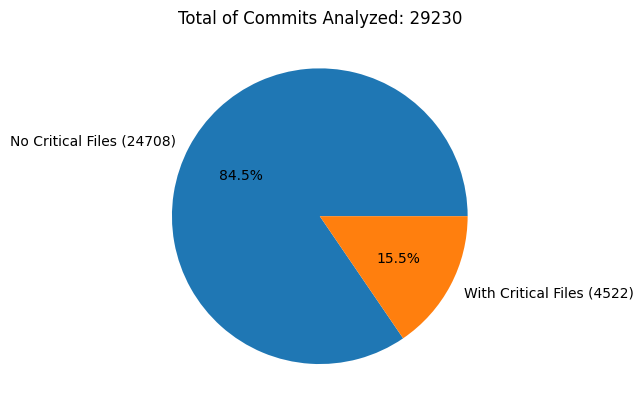

In [ ]:
my_qtd_commits_to_analyze= commits_to_analyze[1]
my_commits_to_analyze = commits_to_analyze[0]
qtd_commits_with_critical_files = len(my_commits_to_analyze.keys())
qtd_commits_no_critical_files = my_qtd_commits_to_analyze - qtd_commits_with_critical_files

print(f'Total de commits analisados: {my_qtd_commits_to_analyze}')
print(f'Commits que possuem pelo menos um arquivo crítico: {qtd_commits_with_critical_files}')
print(f'Commits sem arquivos críticos: {qtd_commits_no_critical_files}')
print('\n')

plt.pie([qtd_commits_no_critical_files, qtd_commits_with_critical_files], labels=[f"No Critical Files ({qtd_commits_no_critical_files})", f"With Critical Files ({qtd_commits_with_critical_files})"], autopct="%1.1f%%")
plt.title(f"Total of Commits Analyzed: {my_qtd_commits_to_analyze}")
plt.show()

In [ ]:
MESSAGE_COMMIT = 0
CRITICAL_FILES_COMMIT = 1
DATE_COMMIT = 2
LINES_COMMIT = 3
FILES_COMMIT = 4
DICT_DIFF_COMMIT = 5
MODIFIED_FILES_COMMIT = 6
DICT_MODIFIED_FILES_COMMIT = 7

l_commits_aux, l_msg_aux, l_critical_files_aux, l_date_aux, l_lines_aux, l_files_commit_aux, l_diff_commit_aux, l_modified_files_aux, l_dict_modified_files = [], [], [], [], [], [], [], [], []

dict_commits_to_analyse = commits_to_analyze[0]
for k, v in dict_commits_to_analyse.items():
  l_commits_aux.append(k)
  l_msg_aux.append(v[MESSAGE_COMMIT])
  l_critical_files_aux.append(v[CRITICAL_FILES_COMMIT])
  l_date_aux.append(v[DATE_COMMIT])
  l_lines_aux.append(v[LINES_COMMIT])
  l_files_commit_aux.append(v[FILES_COMMIT])
  l_diff_commit_aux.append(v[DICT_DIFF_COMMIT])
  l_modified_files_aux.append(v[MODIFIED_FILES_COMMIT])
  l_dict_modified_files.append(v[DICT_MODIFIED_FILES_COMMIT])

dict_commits_to_analyze_aux = {
	'commits':l_commits_aux,
	'msg': l_msg_aux,
	'critical_files': l_critical_files_aux,
  'data': l_date_aux,
	'lines': l_lines_aux,
  'files': l_files_commit_aux,
	'diff_commit': l_diff_commit_aux,
	'modified_files': l_modified_files_aux,
	'dict_modified_files': l_dict_modified_files
}

df_commits_to_analyze_aux = pd.DataFrame(dict_commits_to_analyze_aux)
df_commits_to_analyze_aux

,commits,msg,critical_files,data,lines,files,diff_commit,modified_files,dict_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...",2/3/2009,74502,344,"[{'DatabaseDescriptor.java': '@@ -0,0 +1,743 @...","[JSAP-2.1.jar, activation.jar, antlr-2.7.6.jar...",[Binary files /dev/null and b/lib/JSAP-2.1.jar...
1,cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3,Add build script and make sure it works\n\ngit...,[StorageService.java],2/3/2009,156,4,"[{'StorageService.java': '@@ -70,11 +70,6 @@ i...","[build.xml, StorageService.java, DBTest.java, ...","[@@ -0,0 +1,133 @@\n+<?xml version=""1.0"" encod..."
2,5bea7e1772e9fd042b10abebb1e0c78579942b26,Removed references to JDK7 specific things.\n\...,[ColumnFamilyStore.java],20/3/2009,82,2,"[{'ColumnFamilyStore.java': '@@ -20,7 +20,6 @@...","[ColumnFamilyStore.java, Table.java]","[@@ -20,7 +20,6 @@ package org.apache.cassandr..."
3,f4f3ca50d84e165a909dca5608babb32df199f44,rename serializer2 -> serializerWithIndexers\n...,[ColumnFamilyStore.java],27/3/2009,26,4,"[{'ColumnFamilyStore.java': '@@ -22,10 +22,7 @...","[ColumnFamily.java, ColumnFamilyStore.java, Me...","[@@ -70,7 +70,7 @@ public final class ColumnFa..."
4,39d3f833f9c4e154eb157336f5e7b2a1ce9a79a3,add SuperColumn support to forceFlush. split ...,[ColumnFamilyStore.java],27/3/2009,89,5,"[{'ColumnFamilyStore.java': '@@ -395,11 +395,1...","[ColumnFamilyStore.java, HintedHandOffManager....","[@@ -395,11 +395,11 @@ public class ColumnFami..."
...,...,...,...,...,...,...,...,...,...
4517,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,[CassandraDaemon.java],12/9/2023,105,10,"[{'CassandraDaemon.java': '@@ -21,7 +21,6 @@ i...","[build-rat.xml, CHANGES.txt, NEWS.txt, jvm-ser...","[@@ -43,7 +43,6 @@\n <!-- Con..."
4518,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,[Config.java],19/9/2023,289,11,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
4519,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,[CompactionManager.java],25/9/2023,724,18,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
4520,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,[MessagingService.java],25/9/2023,237,13,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


### Incidência dos Arquivos Críticos nos Commits

In [ ]:
print('Quantidade de vezes que cada arquivo crítico aparece nos commits')
df_critical_files_in_commits = get_df_critical_files_in_commits(lista_arquivos_criticos, my_commits_to_analyze)
df_critical_files_in_commits

Quantidade de vezes que cada arquivo crítico aparece nos commits


,file,appears_in_commits
0,StorageService.java,1317
1,ColumnFamilyStore.java,1178
2,DatabaseDescriptor.java,854
3,CompactionManager.java,572
4,StorageProxy.java,668
5,SSTableReader.java,500
6,Config.java,457
7,CassandraDaemon.java,328
8,SelectStatement.java,369
9,SinglePartitionReadCommand.java,93


### Incidência dos Arquivos Críticos nos Commits com Issues registrados

In [ ]:
dict_commits_with_issues = get_dict_commits_with_issues(my_commits_to_analyze)

print('Quantidade de vezes que cada arquivo crítico aparece nos commits com issues registrados')
df_critical_files_in_commits_with_issues = get_df_critical_files_in_commits_with_issues(lista_arquivos_criticos, dict_commits_with_issues)
df_critical_files_in_commits_with_issues

Quantidade de vezes que cada arquivo crítico aparece nos commits com issues registrados


,file,appears_in_commits_with_issues
0,StorageService.java,1034
1,ColumnFamilyStore.java,893
2,DatabaseDescriptor.java,697
3,CompactionManager.java,445
4,StorageProxy.java,506
5,SSTableReader.java,393
6,Config.java,399
7,CassandraDaemon.java,241
8,SelectStatement.java,303
9,SinglePartitionReadCommand.java,85


### Incidência dos Arquivos Críticos nos Commits e nos Commits com Issues registrados

Merge dos dados incidência nos commits e incidência nos commits com issues

In [ ]:
df_critical_files_in_commits_and_with_issues = pd.merge(df_critical_files_in_commits, df_critical_files_in_commits_with_issues, how='inner')
df_critical_files_in_commits_and_with_issues

,file,appears_in_commits,appears_in_commits_with_issues
0,StorageService.java,1317,1034
1,ColumnFamilyStore.java,1178,893
2,DatabaseDescriptor.java,854,697
3,CompactionManager.java,572,445
4,StorageProxy.java,668,506
5,SSTableReader.java,500,393
6,Config.java,457,399
7,CassandraDaemon.java,328,241
8,SelectStatement.java,369,303
9,SinglePartitionReadCommand.java,93,85


Incidência dos arquivos críticos nos commits e nos commits com issues


<Axes: >

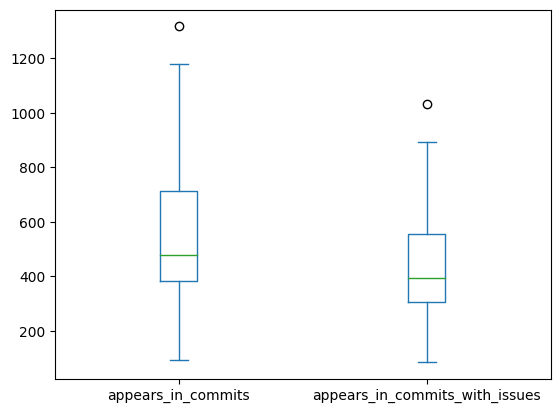

In [ ]:
print('Incidência dos arquivos críticos nos commits e nos commits com issues')
df_teste = df_critical_files_in_commits_and_with_issues[['appears_in_commits', 'appears_in_commits_with_issues']]
df_teste.plot(kind='box')

### Merge dos dados dos arquivos criticos

- AMLOC (by ATDCodeAnalyzer)
- FOC (by ATDCodeAnalyzer)
- CC (by ATDCodeAnalyzer)
- commits
- commits com issues
- appears in bugs
- appears in improvements
- appears in new features

In [ ]:
data_a = {
    'file': [
        'StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java',
        'CompactionManager.java', 'StorageProxy.java', 'Config.java',
        'MessagingService.java', 'SSTableReader.java', 'NodeProbe.java',
        'SelectStatement.java', 'CassandraDaemon.java', 'SinglePartitionReadCommand.java'
    ],
    'appears_in_bugs': [
        160.0, 139.0, 90.0, 72.0, 71.0, 58.0, 50.0, 47.0, 39.0, 39.0, 28.0, 5.0
    ],
    'AMLOC': [
        3537, 1966, 2092, 1279, 1667, 553, 574, 767, 513, 1174, 1001, 994
    ],
    'FOC': [
        144, 89, 87, 74, 53, 52, 36, 53, 37, 44, 51, 38
    ],
    'CC': [
        838, 373, 471, 265, 377, 12, 165, 324, 255, 177, 117, 157
    ],
    'composition': [
        426816864, 65265302, 85723884, 25081190, 33308327, 345072, 3409560,
        13170924, 4840155, 9143112, 5972967, 5930204
    ]
}

data_b = {
    'file': [
        'StorageService.java', 'ColumnFamilyStore.java', 'DatabaseDescriptor.java',
        'StorageProxy.java', 'CompactionManager.java', 'Config.java',
        'SSTableReader.java', 'MessagingService.java', 'NodeProbe.java',
        'SelectStatement.java', 'CassandraDaemon.java', 'SinglePartitionReadCommand.java'
    ],
    'appears_in_issues': [
        967.0, 832.0, 659.0, 463.0, 406.0, 379.0, 352.0, 288.0, 287.0, 245.0, 235.0, 83.0
    ],
    'AMLOC': [
        3537, 1966, 2092, 1667, 1279, 553, 767, 574, 513, 1174, 1001, 994
    ],
    'FOC': [
        144, 89, 87, 53, 74, 52, 53, 36, 37, 44, 51, 38
    ],
    'CC': [
        838, 373, 471, 377, 265, 12, 324, 165, 255, 177, 117, 157
    ],
    'composition': [
        426816864, 65265302, 85723884, 33308327, 25081190, 345072, 13170924,
        3409560, 4840155, 9143112, 5972967, 5930204
    ]
}

# Create a list of data of issues
data_improvement_issues = [
    ["ColumnFamilyStore.java", 96],
    ["StorageService.java", 79],
    ["DatabaseDescriptor.java", 62],
    ["StorageProxy.java", 55],
    ["SSTableReader.java", 48],
    ["CompactionManager.java", 47],
    ["Config.java", 37],
    ["CassandraDaemon.java", 34],
    ["MessagingService.java", 31],
    ["NodeProbe.java", 26],
    ["SelectStatement.java", 25],
    ["SinglePartitionReadCommand.java", 5],
]

# Create a list of data
data_new_features = [
    ["CompactionManager.java", 5],
    ["CassandraDaemon.java", 5],
    ["DatabaseDescriptor.java", 4],
    ["StorageService.java", 3],
    ["Config.java", 3],
    ["ColumnFamilyStore.java", 3],
    ["StorageProxy.java", 2],
    ["NodeProbe.java", 2],
    ["SinglePartitionReadCommand.java", 1],
    ["MessagingService.java", 1],
    ["SSTableReader.java", 1],
    ["SelectStatement.java", 0],
]

df_new_features = pd.DataFrame(data_new_features, columns=["file_x", "appears_in_new_feature_issues"])
df_improvement_issues = pd.DataFrame(data_improvement_issues, columns=["file_x", "appears_in_improvement_issues"])

df_bugs = pd.DataFrame(data_a)
df_issues = pd.DataFrame(data_b)
df_critical_files_issues_bug = pd.merge(df_issues, df_bugs, how='inner')

df_critical_files_info = pd.merge(df_critical_files_issues_bug, df_critical_files_in_commits_and_with_issues, how='inner', on=df_critical_files_issues_bug.file)
df_critical_files_info = df_critical_files_info[['file_x', 'AMLOC', 'FOC', 'CC', 'composition', 'appears_in_commits', 'appears_in_commits_with_issues', 'appears_in_issues', 'appears_in_bugs']]

df_critical_files_improvement_new_features = pd.merge(df_improvement_issues, df_new_features, how='inner')
df_critical_files_info_full = pd.merge(df_critical_files_info, df_critical_files_improvement_new_features, how='inner')
df_critical_files_info_full


,file_x,AMLOC,FOC,CC,composition,appears_in_commits,appears_in_commits_with_issues,appears_in_issues,appears_in_bugs,appears_in_improvement_issues,appears_in_new_feature_issues
0,StorageService.java,3537,144,838,426816864,1317,1034,967.0,160.0,79,3
1,ColumnFamilyStore.java,1966,89,373,65265302,1178,893,832.0,139.0,96,3
2,DatabaseDescriptor.java,2092,87,471,85723884,854,697,659.0,90.0,62,4
3,StorageProxy.java,1667,53,377,33308327,572,445,463.0,71.0,55,2
4,CompactionManager.java,1279,74,265,25081190,668,506,406.0,72.0,47,5
5,Config.java,553,52,12,345072,500,393,379.0,58.0,37,3
6,SSTableReader.java,767,53,324,13170924,457,399,352.0,47.0,48,1
7,MessagingService.java,574,36,165,3409560,328,241,288.0,50.0,31,1
8,NodeProbe.java,513,37,255,4840155,369,303,287.0,39.0,26,2
9,SelectStatement.java,1174,44,177,9143112,93,85,245.0,39.0,25,0


In [ ]:
column_names = [
    "file_x",
    "appears_in_commits",
    "appears_in_commits_with_issues",
    "appears_in_issues",
    "appears_in_bugs",
    "appears_in_improvement_issues",
    "appears_in_new_feature_issues",
]
df_critical_files_info_commits_issue = df_critical_files_info_full[column_names]
df_critical_files_info_commits_issue

,file_x,appears_in_commits,appears_in_commits_with_issues,appears_in_issues,appears_in_bugs,appears_in_improvement_issues,appears_in_new_feature_issues
0,StorageService.java,1317,1034,967.0,160.0,79,3
1,ColumnFamilyStore.java,1178,893,832.0,139.0,96,3
2,DatabaseDescriptor.java,854,697,659.0,90.0,62,4
3,StorageProxy.java,572,445,463.0,71.0,55,2
4,CompactionManager.java,668,506,406.0,72.0,47,5
5,Config.java,500,393,379.0,58.0,37,3
6,SSTableReader.java,457,399,352.0,47.0,48,1
7,MessagingService.java,328,241,288.0,50.0,31,1
8,NodeProbe.java,369,303,287.0,39.0,26,2
9,SelectStatement.java,93,85,245.0,39.0,25,0


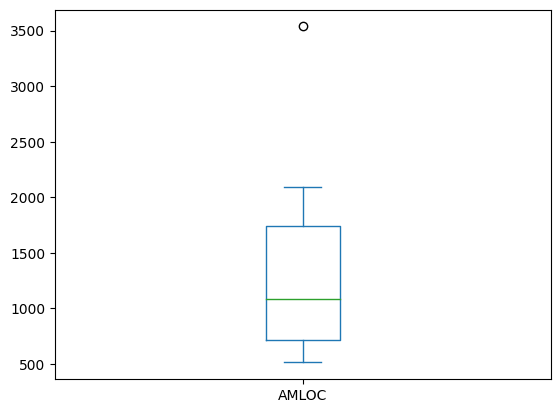

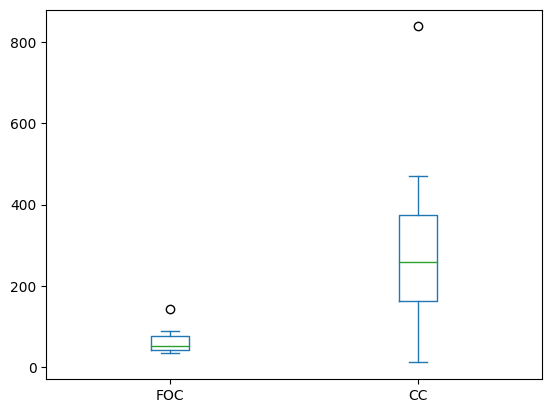

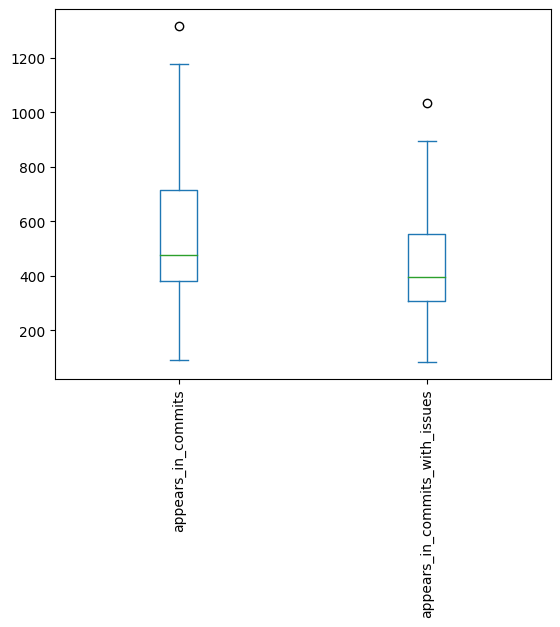

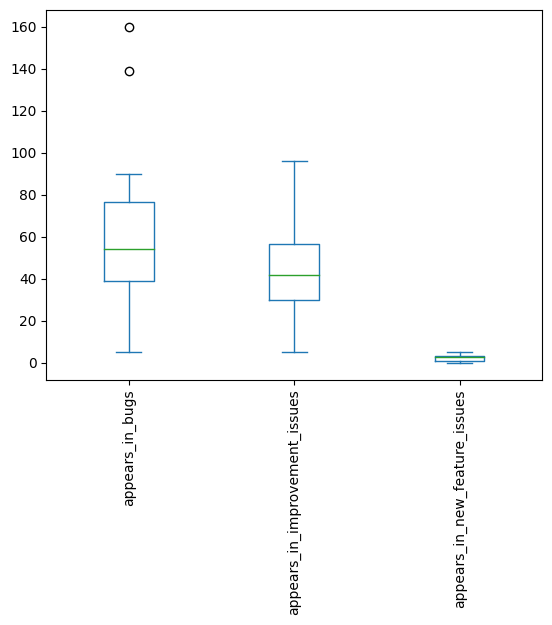

In [ ]:
df_teste_info1 = df_critical_files_info_full[['AMLOC']]
df_teste_info1.plot(kind='box', )

df_teste_info1_1 = df_critical_files_info_full[['FOC','CC']]
df_teste_info1_1.plot(kind='box', )

df_teste_info2 = df_critical_files_info_commits_issue[['appears_in_commits','appears_in_commits_with_issues']]
df_teste_info2.plot(kind='box')
plt.xticks(rotation=90)
plt.show()

df_teste_info3 = df_critical_files_info_commits_issue[['appears_in_bugs',"appears_in_improvement_issues","appears_in_new_feature_issues"]]
df_teste_info3.plot(kind='box')
plt.xticks(rotation=90)
plt.show()

### Cálculo da correlação entre as métricas analisadas

<Axes: >

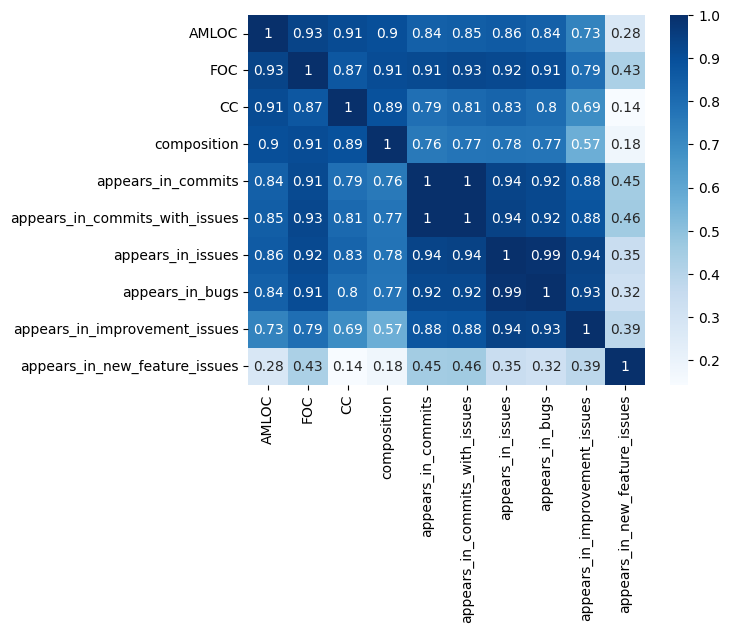

In [ ]:
# calculate the correlation matrix on the numeric columns
corr = df_critical_files_info_full.select_dtypes('number').corr()

sns.heatmap(corr, cmap='Blues', annot=True)

<Axes: >

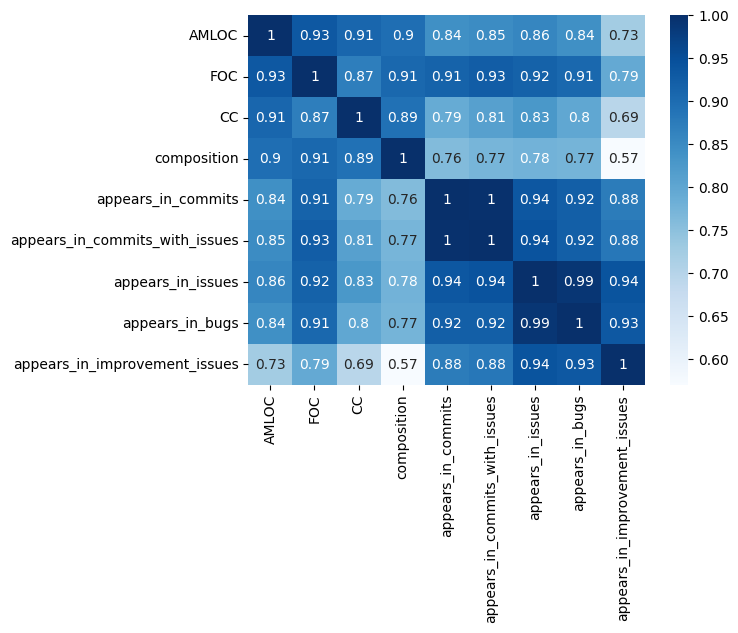

In [ ]:
list_main_columns = ['file_x', 'AMLOC', 'FOC', 'CC', 'composition', 'appears_in_commits',
       'appears_in_commits_with_issues', 'appears_in_issues',
       'appears_in_bugs', 'appears_in_improvement_issues']

# calculate the correlation matrix on the numeric columns
df_critical_files_info_full_2 = df_critical_files_info_full[list_main_columns].copy()
corr2 = df_critical_files_info_full_2.select_dtypes('number').corr()

sns.heatmap(corr2, cmap='Blues', annot=True)

### Conjunto de Commits com Arquivos Críticos (by ATDCodeAnalyzer)

In [ ]:
list_comits_with_critical_files = df_commits_to_analyze_aux.commits.to_list()
print('Commits com Arquivos Críticos (by ATDCodeAnalyzer)')
print(f'{len(list_comits_with_critical_files)}, {list_comits_with_critical_files}')
print('\n')
print('Convert list_comits_with_critical_files para um conjunto de commits')
set_comits_with_critical_files = set(list_comits_with_critical_files)

Commits com Arquivos Críticos (by ATDCodeAnalyzer)
4522, ['1f91e99223b0d1b7ed8390400d4a06ac08e4aa85', 'cf56f8f3acbeac0ddff9ee3131ad7abe2a919ba3', '5bea7e1772e9fd042b10abebb1e0c78579942b26', 'f4f3ca50d84e165a909dca5608babb32df199f44', '39d3f833f9c4e154eb157336f5e7b2a1ce9a79a3', 'b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d', 'ce8a73f2be0406f954f39aa6f6e20863e99e5461', '66dee7aaab26556561614ab056469ade85de5ebd', 'a996c8214baa4fa886071a24b8058ed1ca284686', '4cff66a0eebd138271f3fa5f23fae3df07a7adf7', '20e081f2901384f0786a56fb21a181033aa8e839', '8ce795a0a98cf18444af4c1c1528e6a12caf1320', 'dd61d5119d951d94da28256e5482d580a0685030', 'bf684eea956dbbbf7a35ef3deca8b4462b139136', '4c194aa8d14cc8b473939d3496cd576c4cb397e7', '76f33027535a192ab2d76ac1f01a5a8829c845af', '1866e3802bb16dd582cf5a95bc41bb13e808a0ba', '964dd9bb57230e1973aaede17c520ede1453a210', '52062900caf861e237355c297709976036c70404', '1cc4294d349e4d24c8a0894e3b4748d5f3798f00', 'bd884e4d986ebfa5568a431abc55813a6a903bb5', '2f8268cd099ce32a8

## 5.4 Commits contendo SATD Keywords e contendo Arquivos Críticos

Faz a intersecção entre commits com SATD keywords e commits com arquivos críticos

In [ ]:
set_commits_with_satd_keywords_and_critical_files = set_comits_with_critical_files.intersection(set_list_commit_with_satd_keywords)
list_commits_with_satd_keywords_and_critical_files = list(set_commits_with_satd_keywords_and_critical_files)

df_commits_with_satd_keywords1 = df_commit_diffs_aux[df_commit_diffs_aux['commits'].isin(list_commits_with_satd_keywords_and_critical_files)]

df_commits_with_satd_keywords1.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 4336
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   commits   1734 non-null   object
 1   keywords  1734 non-null   object
 2   comments  1734 non-null   object
dtypes: object(3)
memory usage: 54.2+ KB


In [ ]:
df_commits_with_satd_keywords1

,commits,keywords,comments
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,"[fix, exception, implementation, update, updat...",[\t * Throws an exception if the metrics imple...
2,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...
5,66dee7aaab26556561614ab056469ade85de5ebd,"[TODO, exception, TODO, exception]",[\t\t\t// TODO: throw a thrift exception if we...
6,a996c8214baa4fa886071a24b8058ed1ca284686,"[throughput, output, TODO, clean, test, TODO, ...",[ * high throughput on reads but a...
7,20e081f2901384f0786a56fb21a181033aa8e839,"[TODO, TODO]",[ // TODO this is broken because SST/Se...
...,...,...,...
4326,6708499e4c930f7733894e6076b925fb151d9251,[dependency],[ * Remove metrics-reporter-config dependency ...
4328,20d80118ac02d853d501e3f5c24a63a12d4010f5,"[exception, not thread safe, exception]",[ /** Should throw exception if null client...
4332,d16e8d3653dce8ed767a040c06dbaabc47a9b474,"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...
4333,b9586501a6b6cdfe465302448018785652c9b966,[update],[ * Internode legacy SSL storage port certific...


In [ ]:
df_commits_with_satd_keywords2 = df_commits_to_analyze_aux[df_commits_to_analyze_aux['commits'].isin(list_commits_with_satd_keywords_and_critical_files)]
df_commits_with_satd_keywords2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 4521
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   commits              1734 non-null   object
 1   msg                  1734 non-null   object
 2   critical_files       1734 non-null   object
 3   data                 1734 non-null   object
 4   lines                1734 non-null   int64 
 5   files                1734 non-null   int64 
 6   diff_commit          1734 non-null   object
 7   modified_files       1734 non-null   object
 8   dict_modified_files  1734 non-null   object
dtypes: int64(2), object(7)
memory usage: 135.5+ KB


In [ ]:
df_commits_with_satd_keywords2

,commits,msg,critical_files,data,lines,files,diff_commit,modified_files,dict_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,git-svn-id: https://svn.apache.org/repos/asf/i...,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...",2/3/2009,74502,344,"[{'DatabaseDescriptor.java': '@@ -0,0 +1,743 @...","[JSAP-2.1.jar, activation.jar, antlr-2.7.6.jar...",[Binary files /dev/null and b/lib/JSAP-2.1.jar...
5,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,add deletion marker support to Column (boolean...,[ColumnFamilyStore.java],27/3/2009,997,11,"[{'ColumnFamilyStore.java': '@@ -614,17 +614,6...","[AbstractColumnFactory.java, Column.java, Colu...","[@@ -31,13 +31,13 @@ import java.util.StringTo..."
7,66dee7aaab26556561614ab056469ade85de5ebd,finish remove support. Split CFS.resolve() in...,"[ColumnFamilyStore.java, StorageProxy.java]",27/3/2009,536,8,"[{'ColumnFamilyStore.java': '@@ -18,15 +18,27 ...","[ColumnFamilyStore.java, HintedHandOffManager....","[@@ -18,15 +18,27 @@\n \r\n package org.apache..."
8,a996c8214baa4fa886071a24b8058ed1ca284686,test support. this requires some refactoring ...,"[DatabaseDescriptor.java, StorageService.java]",27/3/2009,1356,26,"[{'DatabaseDescriptor.java': '@@ -25,6 +25,8 @...","[build.xml, DatabaseDescriptor.java, BinaryMem...","[@@ -8,6 +8,8 @@\n <property name=""build.l..."
10,20e081f2901384f0786a56fb21a181033aa8e839,consolidates partition behavior in IPartitione...,"[ColumnFamilyStore.java, StorageService.java]",27/3/2009,1263,18,"[{'ColumnFamilyStore.java': '@@ -1269,39 +1269...","[ColumnFamilyStore.java, FileStruct.java, Memt...","[@@ -1269,39 +1269,10 @@ public class ColumnFa..."
...,...,...,...,...,...,...,...,...,...
4517,6708499e4c930f7733894e6076b925fb151d9251,Remove metrics-reporter-config dependency\n\np...,[CassandraDaemon.java],12/9/2023,105,10,"[{'CassandraDaemon.java': '@@ -21,7 +21,6 @@ i...","[build-rat.xml, CHANGES.txt, NEWS.txt, jvm-ser...","[@@ -43,7 +43,6 @@\n <!-- Con..."
4518,20d80118ac02d853d501e3f5c24a63a12d4010f5,Add the ability to disable bulk loading of SST...,[Config.java],19/9/2023,289,11,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
4519,d16e8d3653dce8ed767a040c06dbaabc47a9b474,Do not create sstable files before registering...,[CompactionManager.java],25/9/2023,724,18,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
4520,b9586501a6b6cdfe465302448018785652c9b966,Internode legacy SSL storage port certificate ...,[MessagingService.java],25/9/2023,237,13,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


In [ ]:
df_commits_with_satd_keywords_with_critical_files = df_commits_with_satd_keywords1.merge(df_commits_with_satd_keywords2, on='commits', how='outer')

colunas_ok = ['commits', 'data', 'msg', 'lines', 'files', 'critical_files', 'keywords', 'comments',
       'diff_commit', 'modified_files','dict_modified_files']

df_commits_with_satd_keywords_with_critical_files = df_commits_with_satd_keywords_with_critical_files[colunas_ok]
df_commits_with_satd_keywords_with_critical_files.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1734 entries, 0 to 1733
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   commits              1734 non-null   object
 1   data                 1734 non-null   object
 2   msg                  1734 non-null   object
 3   lines                1734 non-null   int64 
 4   files                1734 non-null   int64 
 5   critical_files       1734 non-null   object
 6   keywords             1734 non-null   object
 7   comments             1734 non-null   object
 8   diff_commit          1734 non-null   object
 9   modified_files       1734 non-null   object
 10  dict_modified_files  1734 non-null   object
dtypes: int64(2), object(9)
memory usage: 162.6+ KB


In [ ]:
df_commits_with_satd_keywords_with_critical_files

,commits,data,msg,lines,files,critical_files,keywords,comments,diff_commit,modified_files,dict_modified_files
0,1f91e99223b0d1b7ed8390400d4a06ac08e4aa85,2/3/2009,git-svn-id: https://svn.apache.org/repos/asf/i...,74502,344,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[fix, exception, implementation, update, updat...",[\t * Throws an exception if the metrics imple...,"[{'DatabaseDescriptor.java': '@@ -0,0 +1,743 @...","[JSAP-2.1.jar, activation.jar, antlr-2.7.6.jar...",[Binary files /dev/null and b/lib/JSAP-2.1.jar...
1,b6ae87ba0054ed3bb7ebcf69dfa7d47e92da399d,27/3/2009,add deletion marker support to Column (boolean...,997,11,[ColumnFamilyStore.java],"[TODO, TODO]",[ * (TODO: look at making SuperColumn immutabl...,"[{'ColumnFamilyStore.java': '@@ -614,17 +614,6...","[AbstractColumnFactory.java, Column.java, Colu...","[@@ -31,13 +31,13 @@ import java.util.StringTo..."
2,66dee7aaab26556561614ab056469ade85de5ebd,27/3/2009,finish remove support. Split CFS.resolve() in...,536,8,"[ColumnFamilyStore.java, StorageProxy.java]","[TODO, exception, TODO, exception]",[\t\t\t// TODO: throw a thrift exception if we...,"[{'ColumnFamilyStore.java': '@@ -18,15 +18,27 ...","[ColumnFamilyStore.java, HintedHandOffManager....","[@@ -18,15 +18,27 @@\n \r\n package org.apache..."
3,a996c8214baa4fa886071a24b8058ed1ca284686,27/3/2009,test support. this requires some refactoring ...,1356,26,"[DatabaseDescriptor.java, StorageService.java]","[throughput, output, TODO, clean, test, TODO, ...",[ * high throughput on reads but a...,"[{'DatabaseDescriptor.java': '@@ -25,6 +25,8 @...","[build.xml, DatabaseDescriptor.java, BinaryMem...","[@@ -8,6 +8,8 @@\n <property name=""build.l..."
4,20e081f2901384f0786a56fb21a181033aa8e839,27/3/2009,consolidates partition behavior in IPartitione...,1263,18,"[ColumnFamilyStore.java, StorageService.java]","[TODO, TODO]",[ // TODO this is broken because SST/Se...,"[{'ColumnFamilyStore.java': '@@ -1269,39 +1269...","[ColumnFamilyStore.java, FileStruct.java, Memt...","[@@ -1269,39 +1269,10 @@ public class ColumnFa..."
...,...,...,...,...,...,...,...,...,...,...,...
1729,6708499e4c930f7733894e6076b925fb151d9251,12/9/2023,Remove metrics-reporter-config dependency\n\np...,105,10,[CassandraDaemon.java],[dependency],[ * Remove metrics-reporter-config dependency ...,"[{'CassandraDaemon.java': '@@ -21,7 +21,6 @@ i...","[build-rat.xml, CHANGES.txt, NEWS.txt, jvm-ser...","[@@ -43,7 +43,6 @@\n <!-- Con..."
1730,20d80118ac02d853d501e3f5c24a63a12d4010f5,19/9/2023,Add the ability to disable bulk loading of SST...,289,11,[Config.java],"[exception, not thread safe, exception]",[ /** Should throw exception if null client...,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
1731,d16e8d3653dce8ed767a040c06dbaabc47a9b474,25/9/2023,Do not create sstable files before registering...,724,18,[CompactionManager.java],"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
1732,b9586501a6b6cdfe465302448018785652c9b966,25/9/2023,Internode legacy SSL storage port certificate ...,237,13,[MessagingService.java],[update],[ * Internode legacy SSL storage port certific...,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


Total de commits analisados: 29230
Commits que possuem pelo menos um arquivo crítico: 4522
Qtd de commits sem SATD e sem arquivos críticos: 27496
Qtd de commits com SATD e arquivos críticos: 1734




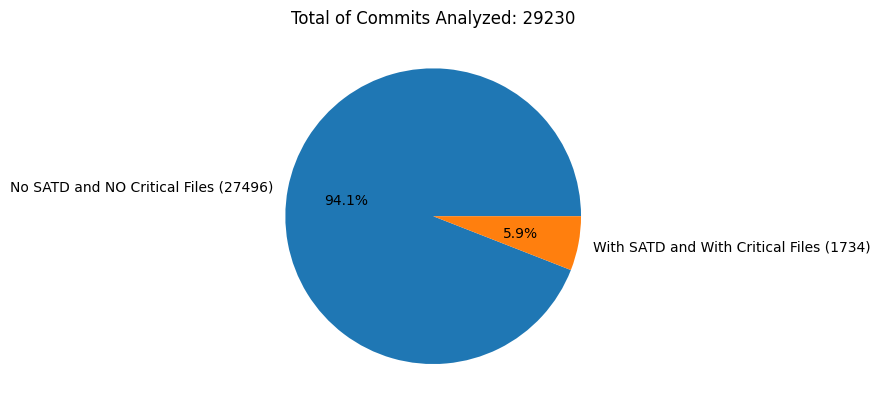

In [ ]:
qtd_commits_with_satd_and_critical_files = len(df_commits_with_satd_keywords_with_critical_files.commits.to_list())
qtd_commits_no_satd_no_critical_files = my_qtd_commits_to_analyze - qtd_commits_with_satd_and_critical_files

# Dos x commits com arquivos criticos quantos tem SATD?
print(f'Total de commits analisados: {my_qtd_commits_to_analyze}')
print(f'Commits que possuem pelo menos um arquivo crítico: {qtd_commits_with_critical_files}')
print(f'Qtd de commits sem SATD e sem arquivos críticos: {qtd_commits_no_satd_no_critical_files}')
print(f'Qtd de commits com SATD e arquivos críticos: {qtd_commits_with_satd_and_critical_files}')
print(f'\n')

plt.pie([qtd_commits_no_satd_no_critical_files, qtd_commits_with_satd_and_critical_files], labels=[f"No SATD and NO Critical Files ({qtd_commits_no_satd_no_critical_files})", f"With SATD and With Critical Files ({qtd_commits_with_satd_and_critical_files})"], autopct="%1.1f%%")
plt.title(f"Total of Commits Analyzed: {my_qtd_commits_to_analyze}")
plt.show()

In [ ]:
print('Salva o dataframe de df_commits_with_satd_keywords_with_critical_files em uma planilha excel')
df_commits_with_satd_keywords_with_critical_files.to_excel('commits_with_satd_keywords_with_critical_files.xlsx')

Salva o dataframe de df_commits_with_satd_keywords_with_critical_files em uma planilha excel


# 6. Analyzes Jira issues

## 6.1 Configures the instance, project and date range

In [ ]:
# Initialize the Jira connection
print('Initialize the Jira connection')
jira = JIRA(JIRA_SERVER, basic_auth=(username, password))

# Create a JiraUtils instance
print('Create a JiraUtils instance')
jira_utils = JiraUtils('CASSANDRA', jira)

date1 = (2009, 3, 2)
date2 = (2023, 10, 4)
distance = 120
print('Define date intervals')
print(f'From: {str(date1)} to: {date2}, by: {distance} days of distance.')

Initialize the Jira connection
Create a JiraUtils instance
Define date intervals
From: (2009, 3, 2) to: (2023, 10, 4), by: 120 days of distance.


## 6.2 Retrieves all blocks of issues in range of dates

In [ ]:
# Fetch issues using date intervals
print('Fetch issues using date intervals')
block_of_issues = jira_utils.get_list_of_block_issues_by_dates(date1, date2, distance)

Fetch issues using date intervals
Aguarde...


Progress Message Analysis:   2%|▏         | 1/45 [00:03<02:40,  3.64s/it]

Range: project=CASSANDRA and created>="2009/03/02" and created<="2009/06/29", qtd issues: 263


Progress Message Analysis:   4%|▍         | 2/45 [00:06<02:24,  3.37s/it]

Range: project=CASSANDRA and created>="2009/06/30" and created<="2009/10/27", qtd issues: 251


Progress Message Analysis:   7%|▋         | 3/45 [00:10<02:32,  3.62s/it]

Range: project=CASSANDRA and created>="2009/10/28" and created<="2010/02/24", qtd issues: 310


Progress Message Analysis:   9%|▉         | 4/45 [00:15<02:42,  3.96s/it]

Range: project=CASSANDRA and created>="2010/02/25" and created<="2010/06/24", qtd issues: 388


Progress Message Analysis:  11%|█         | 5/45 [00:20<02:56,  4.40s/it]

Range: project=CASSANDRA and created>="2010/06/25" and created<="2010/10/22", qtd issues: 419


Progress Message Analysis:  13%|█▎        | 6/45 [00:26<03:14,  4.99s/it]

Range: project=CASSANDRA and created>="2010/10/23" and created<="2011/02/19", qtd issues: 545


Progress Message Analysis:  16%|█▌        | 7/45 [00:33<03:39,  5.77s/it]

Range: project=CASSANDRA and created>="2011/02/20" and created<="2011/06/19", qtd issues: 593


Progress Message Analysis:  18%|█▊        | 8/45 [00:40<03:40,  5.97s/it]

Range: project=CASSANDRA and created>="2011/06/20" and created<="2011/10/17", qtd issues: 573


Progress Message Analysis:  20%|██        | 9/45 [00:46<03:42,  6.19s/it]

Range: project=CASSANDRA and created>="2011/10/18" and created<="2012/02/14", qtd issues: 532


Progress Message Analysis:  22%|██▏       | 10/45 [00:52<03:24,  5.86s/it]

Range: project=CASSANDRA and created>="2012/02/15" and created<="2012/06/13", qtd issues: 423


Progress Message Analysis:  24%|██▍       | 11/45 [00:57<03:10,  5.61s/it]

Range: project=CASSANDRA and created>="2012/06/14" and created<="2012/10/11", qtd issues: 441


Progress Message Analysis:  27%|██▋       | 12/45 [01:03<03:07,  5.69s/it]

Range: project=CASSANDRA and created>="2012/10/12" and created<="2013/02/08", qtd issues: 433


Progress Message Analysis:  29%|██▉       | 13/45 [01:07<02:49,  5.29s/it]

Range: project=CASSANDRA and created>="2013/02/09" and created<="2013/06/08", qtd issues: 386


Progress Message Analysis:  31%|███       | 14/45 [01:13<02:56,  5.69s/it]

Range: project=CASSANDRA and created>="2013/06/09" and created<="2013/10/06", qtd issues: 522


Progress Message Analysis:  33%|███▎      | 15/45 [01:19<02:53,  5.78s/it]

Range: project=CASSANDRA and created>="2013/10/07" and created<="2014/02/03", qtd issues: 492


Progress Message Analysis:  36%|███▌      | 16/45 [01:29<03:22,  6.98s/it]

Range: project=CASSANDRA and created>="2014/02/04" and created<="2014/06/03", qtd issues: 690


Progress Message Analysis:  38%|███▊      | 17/45 [01:39<03:36,  7.72s/it]

Range: project=CASSANDRA and created>="2014/06/04" and created<="2014/10/01", qtd issues: 680


Progress Message Analysis:  40%|████      | 18/45 [01:48<03:44,  8.32s/it]

Range: project=CASSANDRA and created>="2014/10/02" and created<="2015/01/29", qtd issues: 655


Progress Message Analysis:  42%|████▏     | 19/45 [01:58<03:44,  8.62s/it]

Range: project=CASSANDRA and created>="2015/01/30" and created<="2015/05/29", qtd issues: 802


Progress Message Analysis:  44%|████▍     | 20/45 [02:08<03:48,  9.15s/it]

Range: project=CASSANDRA and created>="2015/05/30" and created<="2015/09/26", qtd issues: 875


Progress Message Analysis:  47%|████▋     | 21/45 [02:16<03:27,  8.66s/it]

Range: project=CASSANDRA and created>="2015/09/27" and created<="2016/01/24", qtd issues: 659


Progress Message Analysis:  49%|████▉     | 22/45 [02:26<03:33,  9.28s/it]

Range: project=CASSANDRA and created>="2016/01/25" and created<="2016/05/23", qtd issues: 769


Progress Message Analysis:  51%|█████     | 23/45 [02:35<03:20,  9.11s/it]

Range: project=CASSANDRA and created>="2016/05/24" and created<="2016/09/20", qtd issues: 787


Progress Message Analysis:  53%|█████▎    | 24/45 [02:40<02:47,  7.97s/it]

Range: project=CASSANDRA and created>="2016/09/21" and created<="2017/01/18", qtd issues: 453


Progress Message Analysis:  56%|█████▌    | 25/45 [02:45<02:19,  6.99s/it]

Range: project=CASSANDRA and created>="2017/01/19" and created<="2017/05/18", qtd issues: 403


Progress Message Analysis:  58%|█████▊    | 26/45 [02:49<01:56,  6.12s/it]

Range: project=CASSANDRA and created>="2017/05/19" and created<="2017/09/15", qtd issues: 338


Progress Message Analysis:  60%|██████    | 27/45 [02:53<01:36,  5.35s/it]

Range: project=CASSANDRA and created>="2017/09/16" and created<="2018/01/13", qtd issues: 282


Progress Message Analysis:  62%|██████▏   | 28/45 [02:56<01:19,  4.70s/it]

Range: project=CASSANDRA and created>="2018/01/14" and created<="2018/05/13", qtd issues: 277


Progress Message Analysis:  64%|██████▍   | 29/45 [02:59<01:08,  4.27s/it]

Range: project=CASSANDRA and created>="2018/05/14" and created<="2018/09/10", qtd issues: 265


Progress Message Analysis:  67%|██████▋   | 30/45 [03:02<00:59,  3.97s/it]

Range: project=CASSANDRA and created>="2018/09/11" and created<="2019/01/08", qtd issues: 250


Progress Message Analysis:  69%|██████▉   | 31/45 [03:04<00:46,  3.34s/it]

Range: project=CASSANDRA and created>="2019/01/09" and created<="2019/05/08", qtd issues: 143


Progress Message Analysis:  71%|███████   | 32/45 [03:09<00:47,  3.69s/it]

Range: project=CASSANDRA and created>="2019/05/09" and created<="2019/09/05", qtd issues: 177


Progress Message Analysis:  73%|███████▎  | 33/45 [03:11<00:39,  3.28s/it]

Range: project=CASSANDRA and created>="2019/09/06" and created<="2020/01/03", qtd issues: 164


Progress Message Analysis:  76%|███████▌  | 34/45 [03:15<00:39,  3.55s/it]

Range: project=CASSANDRA and created>="2020/01/04" and created<="2020/05/02", qtd issues: 306


Progress Message Analysis:  78%|███████▊  | 35/45 [03:19<00:36,  3.61s/it]

Range: project=CASSANDRA and created>="2020/05/03" and created<="2020/08/30", qtd issues: 300


Progress Message Analysis:  80%|████████  | 36/45 [03:23<00:32,  3.60s/it]

Range: project=CASSANDRA and created>="2020/08/31" and created<="2020/12/28", qtd issues: 284


Progress Message Analysis:  82%|████████▏ | 37/45 [03:26<00:29,  3.63s/it]

Range: project=CASSANDRA and created>="2020/12/29" and created<="2021/04/27", qtd issues: 262


Progress Message Analysis:  84%|████████▍ | 38/45 [03:29<00:24,  3.45s/it]

Range: project=CASSANDRA and created>="2021/04/28" and created<="2021/08/25", qtd issues: 244


Progress Message Analysis:  87%|████████▋ | 39/45 [03:34<00:21,  3.65s/it]

Range: project=CASSANDRA and created>="2021/08/26" and created<="2021/12/23", qtd issues: 342


Progress Message Analysis:  89%|████████▉ | 40/45 [03:37<00:18,  3.72s/it]

Range: project=CASSANDRA and created>="2021/12/24" and created<="2022/04/22", qtd issues: 340


Progress Message Analysis:  91%|█████████ | 41/45 [03:41<00:14,  3.59s/it]

Range: project=CASSANDRA and created>="2022/04/23" and created<="2022/08/20", qtd issues: 267


Progress Message Analysis:  93%|█████████▎| 42/45 [03:44<00:10,  3.58s/it]

Range: project=CASSANDRA and created>="2022/08/21" and created<="2022/12/18", qtd issues: 273


Progress Message Analysis:  96%|█████████▌| 43/45 [03:48<00:07,  3.69s/it]

Range: project=CASSANDRA and created>="2022/12/19" and created<="2023/04/17", qtd issues: 328


Progress Message Analysis:  98%|█████████▊| 44/45 [03:52<00:03,  3.64s/it]

Range: project=CASSANDRA and created>="2023/04/18" and created<="2023/08/15", qtd issues: 298


Progress Message Analysis: 100%|██████████| 45/45 [03:54<00:00,  5.20s/it]

Range: project=CASSANDRA and created>="2023/08/16" and created<="2023/12/13", qtd issues: 150
2023-10-08 15:56:57.141839
Tempo da consulta: 0:03:54.032907


In [ ]:
# Concatenate the block of issues into a single list
print('Concatenate the block of issues into a single list')
all_issues = jira_utils.concatenate_block_of_issues(block_of_issues)

Concatenate the block of issues into a single list
Total de issues recuperados: 18634


## 6.3 Filter SATD issues

Gera uma lista de issues que possuem SATD baseado nas keywords passadas.

In [ ]:
project = 'CASSANDRA'

# Fetch 'all_issues' from your Jira server

# Call the function to analyze Jira issues for SATD
satd_issues = analyze_jira_issues_for_satd(project, final_satd_keywords, all_issues)

Progress jira issues analysis: 100%|██████████| 18634/18634 [00:07<00:00, 2536.64it/s]


In [ ]:
print(f'Mostra um fragmento dos {len(satd_issues.get_issues())} issues com SATD')
cont = 0
for i,each in enumerate(satd_issues.get_issues()):
  print(i+1, each)
  cont += 1
  if cont == 10:
    break

Mostra um fragmento dos 16566 issues com SATD
1 Key: CASSANDRA-263, Summary: get_slice needs to support desc from last column, Type: Bug, Status: Resolved
2 Key: CASSANDRA-261, Summary: get_slice needs offset + limit, Type: Bug, Status: Resolved
3 Key: CASSANDRA-260, Summary: Unable to read all columns in a column family from the CLI, Type: Bug, Status: Resolved
4 Key: CASSANDRA-259, Summary: LRU cache for key positions, Type: New Feature, Status: Resolved
5 Key: CASSANDRA-258, Summary: Enhance describeTable to return Map of Column Family so that it can be programatically parsed, Type: Improvement, Status: Resolved
6 Key: CASSANDRA-257, Summary: Eliminate thrift warnings , Type: Improvement, Status: Resolved
7 Key: CASSANDRA-256, Summary: Improve ListenAddress in Storage-Conf, Type: Improvement, Status: Resolved
8 Key: CASSANDRA-255, Summary: Supercolumn deserialization bug, Type: Bug, Status: Resolved
9 Key: CASSANDRA-254, Summary: clean up sstable constructors, Type: Improvement, Sta

Total de issues analisados: 18634
Issues que possuem pelo menos um SATD keyword: 16566
Issues sem SATD keyword: 2068




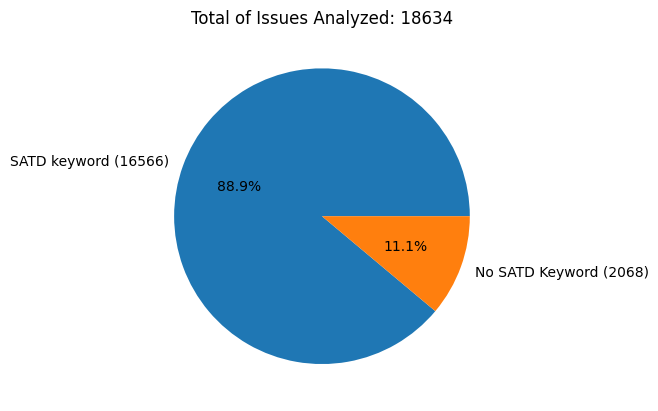

In [ ]:
qtd_issues_analyzed = len(all_issues)
qtd_issues_with_satd_by_keywords = len(satd_issues.get_issues())
qtd_issues_no_satd_by_keywords = qtd_issues_analyzed - qtd_issues_with_satd_by_keywords

print(f'Total de issues analisados: {qtd_issues_analyzed}')
print(f'Issues que possuem pelo menos um SATD keyword: {qtd_issues_with_satd_by_keywords}')
print(f'Issues sem SATD keyword: {qtd_issues_no_satd_by_keywords}')
print('\n')
plt.pie([qtd_issues_with_satd_by_keywords, qtd_issues_no_satd_by_keywords], labels=[f"SATD keyword ({qtd_issues_with_satd_by_keywords})", f"No SATD Keyword ({qtd_issues_no_satd_by_keywords})"], autopct="%1.1f%%")
plt.title(f"Total of Issues Analyzed: {qtd_issues_analyzed}")
plt.show()

In [ ]:
list_issues_with_satd_keywords = []
for each in satd_issues.get_issues():
  list_issues_with_satd_keywords.append(each.key)

print(f'Existem {len(list_issues_with_satd_keywords)} de issues com SATD keyword no summary, description ou comments')

Existem 16566 de issues com SATD keyword no summary, description ou comments


## 6.4 Filtra issues com SATD e que também aparecem nos commits com arquivos críticos

In [ ]:
def find_issues_id_by_project(input_string: str, project: str) -> list[str]:
    """Finds all Cassandra issue ID patterns in the input string.
    Args:
        input_string: The input string.
        project: The pattern related to project name, for example: CASSANDRA project name
    Returns:
        A list of project issue IDs, if found; otherwise, an empty list.
    """
    # Try to find all Cassandra issue ID patterns in the input string
    matches = re.findall(r"({0}-\d+)".format(project), input_string)
    # Return an empty list if no matches are found
    if not matches:
        return []
    # Convert the list of matches to a set to remove duplicates
    set_matches = set(matches)
    # Convert the set of matches back to a list
    list_unique_matches = list(set_matches)

    # Return the list of matched Cassandra issue IDs
    return list_unique_matches

In [ ]:
dict_issues_in_commits = {}
for index in df_commits_with_satd_keywords_with_critical_files.index:
  l_issues_in_commit = find_issues_id_by_project(input_string=df_commits_with_satd_keywords_with_critical_files.msg[index], project='CASSANDRA')
  if len(l_issues_in_commit) > 0:
    commit_hash = df_commits_with_satd_keywords_with_critical_files.commits[index]
    dict_issues_in_commits[commit_hash] = l_issues_in_commit

print(f'Existem {len(dict_issues_in_commits)} issues que foram registrados nos commits. ')

Existem 1496 issues que foram registrados nos commits. 


### Relação de issues com SATD keyword e aparecem nos commits com arquivos críticos

In [ ]:
dict_issues_in_commits_aux = {}
l_issues_in_commits, l_issues_issues_in_commits= [], []

print('Commits que possuem issues registrados em suas mensagens: ')
for k, v in dict_issues_in_commits.items():
  l_issues_in_commits.append(k)
  l_issues_issues_in_commits.append(v)

dict_issues_in_commits_aux = {
    'commits':l_issues_in_commits,
    'issues_ids':l_issues_issues_in_commits
}

df_issues_in_commits_aux = pd.DataFrame(dict_issues_in_commits_aux)
df_issues_in_commits_aux

Commits que possuem issues registrados em suas mensagens: 


,commits,issues_ids
0,907d92e21b8ce79e6a224933764e3b7215a94454,[CASSANDRA-65]
1,296e15b63cdb678a12db004e29359eaf8c14c6c5,[CASSANDRA-65]
2,9db8da81b7f269e5a8a7f896b751d482847d7082,[CASSANDRA-71]
3,219293b2b35453320c78514f9de7724da164638e,[CASSANDRA-130]
4,c3f0d10a8e22cc9a4f76b88ec647a1075f322e0a,[CASSANDRA-144]
...,...,...
1491,6708499e4c930f7733894e6076b925fb151d9251,[CASSANDRA-18743]
1492,20d80118ac02d853d501e3f5c24a63a12d4010f5,[CASSANDRA-18781]
1493,d16e8d3653dce8ed767a040c06dbaabc47a9b474,[CASSANDRA-18737]
1494,b9586501a6b6cdfe465302448018785652c9b966,[CASSANDRA-18681]


Total de issues com SATD: 16566
Issues que possuem pelo menos um SATD keyword registrado em commit com critical file: 1496
Issues sem SATD keyword não registrados nos commits: 15070




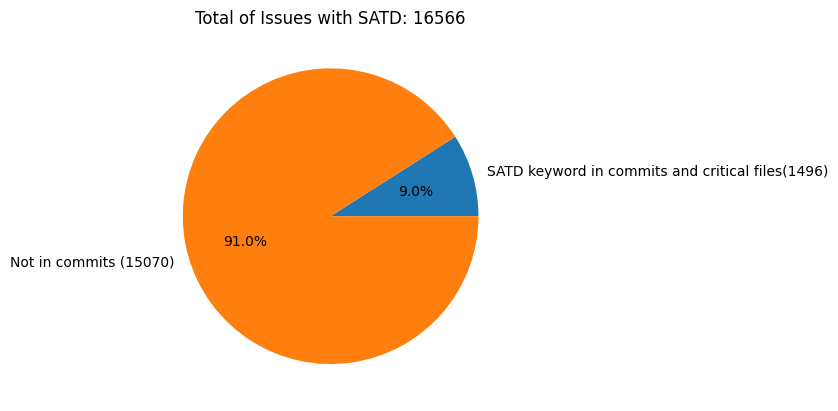

In [ ]:
qtd_issues_with_satd_by_keywords_in_commits_and_critical_files = len(dict_issues_in_commits)
qtd_issues_no_satd_by_keywords_no_in_commits = qtd_issues_with_satd_by_keywords - qtd_issues_with_satd_by_keywords_in_commits_and_critical_files

print(f'Total de issues com SATD: {qtd_issues_with_satd_by_keywords}')
print(f'Issues que possuem pelo menos um SATD keyword registrado em commit com critical file: {qtd_issues_with_satd_by_keywords_in_commits_and_critical_files}')
print(f'Issues sem SATD keyword não registrados nos commits: {qtd_issues_no_satd_by_keywords_no_in_commits}')
print('\n')

plt.pie([qtd_issues_with_satd_by_keywords_in_commits_and_critical_files,qtd_issues_no_satd_by_keywords_no_in_commits], labels=[f"SATD keyword in commits and critical files({qtd_issues_with_satd_by_keywords_in_commits_and_critical_files})", f"Not in commits ({qtd_issues_no_satd_by_keywords_no_in_commits})"], autopct="%1.1f%%")
plt.title(f"Total of Issues with SATD: {qtd_issues_with_satd_by_keywords}")
plt.show()

In [ ]:
list_commits_with_critical_files_and_have_issues_keywords = dict_issues_in_commits.keys()
print('Lista de commits que possuem critical files, SATD keywords e issues registrados com SATD keywords')
print(f'{len(list_commits_with_critical_files_and_have_issues_keywords)}, {list_commits_with_critical_files_and_have_issues_keywords}')

Lista de commits que possuem critical files, SATD keywords e issues registrados com SATD keywords
1496, dict_keys(['907d92e21b8ce79e6a224933764e3b7215a94454', '296e15b63cdb678a12db004e29359eaf8c14c6c5', '9db8da81b7f269e5a8a7f896b751d482847d7082', '219293b2b35453320c78514f9de7724da164638e', 'c3f0d10a8e22cc9a4f76b88ec647a1075f322e0a', '69bc7e97c8dfac3dc6bd3cbfd7fcb05de8d0aedc', '5964cd4c0453866328208574213492fa87e738c9', 'b460bd71c5484d3579dfccaa77a2d2cb0381aea2', '4ac9118f7c7b9162b7ab3ca29ef64c1bbde346a0', '72e6eea9e4ce1fcf30754534216586bcf9e7b041', '01adb7a1aa008372423e4549f9e59bba79c560ca', 'a0c2b2a3809152591d5c5b89fd4b6f1c0a5c9108', '9aeef94db8309764fa241b92c8ee92380e39cafa', '509cbb85de257a9c67311c7dd2fea18ed1b8f096', '2493c9a5651a72aa4c36ff0f080ee3f6c6978dc8', 'f9a1343d92237e6a9553a4fd96db0208b6789126', '81dd8ee5f6e224c550bdf956e0bec3ec2c92cbee', '064a59cdb00361c6b92ce098922b87357cae7736', '4e7f8deac0b4cfdbb24b6b8a304ca5bd289454fe', '261340a3425343c02970082ab6a5248a0d1d84c3', '26ae

In [ ]:
df_commits_with_satd_keywords_with_critical_files_with_issues = df_commits_with_satd_keywords_with_critical_files[df_commits_with_satd_keywords_with_critical_files['commits'].isin(list_commits_with_critical_files_and_have_issues_keywords)]
df_commits_with_satd_keywords_with_critical_files_with_issues

,commits,data,msg,lines,files,critical_files,keywords,comments,diff_commit,modified_files,dict_modified_files
23,907d92e21b8ce79e6a224933764e3b7215a94454,27/4/2009,replace BigInteger tokens with BigIntegerToken...,1090,31,"[ColumnFamilyStore.java, StorageService.java]","[files, test, TODO]",[\t \t //if( !isLoop...,"[{'ColumnFamilyStore.java': '@@ -43,6 +43,7 @@...","[ColumnFamilyStore.java, DBManager.java, FileS...","[@@ -43,6 +43,7 @@ import org.apache.log4j.Log..."
24,296e15b63cdb678a12db004e29359eaf8c14c6c5,27/4/2009,add test for ReplicaPlacementStrategy covering...,77,3,[StorageService.java],[endpoints],[ // make sure that the Strategy picks the ...,"[{'StorageService.java': '@@ -867,6 +867,9 @@ ...","[StringToken.java, StorageService.java, RackUn...","[@@ -2,7 +2,7 @@ package org.apache.cassandra...."
25,9db8da81b7f269e5a8a7f896b751d482847d7082,29/4/2009,"Add range query support, which requires using ...",1456,19,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[interface, interface, TODO, TODO]",[ * Do not mix with calls to the iterator ...,"[{'DatabaseDescriptor.java': '@@ -87,7 +87,7 @...","[cassandra.thrift, Cassandra.java, DatabaseDes...","[@@ -114,6 +114,9 @@ service Cassandra {\n \n ..."
26,219293b2b35453320c78514f9de7724da164638e,4/5/2009,clean up logging. move some of it into MBeans...,493,9,"[ColumnFamilyStore.java, MessagingService.java...",[TODO],[ // TODO send more requests if we ...,"[{'ColumnFamilyStore.java': '@@ -1423,6 +1423,...","[ColumnFamilyStore.java, ColumnFamilyStoreMBea...","[@@ -1423,6 +1423,11 @@ public class ColumnFam..."
27,c3f0d10a8e22cc9a4f76b88ec647a1075f322e0a,6/5/2009,clean up more ad-hoc timing message and move t...,354,9,"[ColumnFamilyStore.java, StorageProxy.java]",[latency],[ * @return average latency per read opera...,"[{'ColumnFamilyStore.java': '@@ -54,6 +54,7 @@...","[ColumnFamilyStore.java, ColumnFamilyStoreMBea...","[@@ -54,6 +54,7 @@ import org.apache.cassandra..."
...,...,...,...,...,...,...,...,...,...,...,...
1729,6708499e4c930f7733894e6076b925fb151d9251,12/9/2023,Remove metrics-reporter-config dependency\n\np...,105,10,[CassandraDaemon.java],[dependency],[ * Remove metrics-reporter-config dependency ...,"[{'CassandraDaemon.java': '@@ -21,7 +21,6 @@ i...","[build-rat.xml, CHANGES.txt, NEWS.txt, jvm-ser...","[@@ -43,7 +43,6 @@\n <!-- Con..."
1730,20d80118ac02d853d501e3f5c24a63a12d4010f5,19/9/2023,Add the ability to disable bulk loading of SST...,289,11,[Config.java],"[exception, not thread safe, exception]",[ /** Should throw exception if null client...,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
1731,d16e8d3653dce8ed767a040c06dbaabc47a9b474,25/9/2023,Do not create sstable files before registering...,724,18,[CompactionManager.java],"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
1732,b9586501a6b6cdfe465302448018785652c9b966,25/9/2023,Internode legacy SSL storage port certificate ...,237,13,[MessagingService.java],[update],[ * Internode legacy SSL storage port certific...,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


In [ ]:
df_commits_with_satd_keywords_with_critical_files_and_issues = df_issues_in_commits_aux.merge(df_commits_with_satd_keywords_with_critical_files_with_issues, on='commits', how='outer')
df_commits_with_satd_keywords_with_critical_files_and_issues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1496 entries, 0 to 1495
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   commits              1496 non-null   object
 1   issues_ids           1496 non-null   object
 2   data                 1496 non-null   object
 3   msg                  1496 non-null   object
 4   lines                1496 non-null   int64 
 5   files                1496 non-null   int64 
 6   critical_files       1496 non-null   object
 7   keywords             1496 non-null   object
 8   comments             1496 non-null   object
 9   diff_commit          1496 non-null   object
 10  modified_files       1496 non-null   object
 11  dict_modified_files  1496 non-null   object
dtypes: int64(2), object(10)
memory usage: 151.9+ KB


In [ ]:
df_commits_with_satd_keywords_with_critical_files_and_issues

,commits,issues_ids,data,msg,lines,files,critical_files,keywords,comments,diff_commit,modified_files,dict_modified_files
0,907d92e21b8ce79e6a224933764e3b7215a94454,[CASSANDRA-65],27/4/2009,replace BigInteger tokens with BigIntegerToken...,1090,31,"[ColumnFamilyStore.java, StorageService.java]","[files, test, TODO]",[\t \t //if( !isLoop...,"[{'ColumnFamilyStore.java': '@@ -43,6 +43,7 @@...","[ColumnFamilyStore.java, DBManager.java, FileS...","[@@ -43,6 +43,7 @@ import org.apache.log4j.Log..."
1,296e15b63cdb678a12db004e29359eaf8c14c6c5,[CASSANDRA-65],27/4/2009,add test for ReplicaPlacementStrategy covering...,77,3,[StorageService.java],[endpoints],[ // make sure that the Strategy picks the ...,"[{'StorageService.java': '@@ -867,6 +867,9 @@ ...","[StringToken.java, StorageService.java, RackUn...","[@@ -2,7 +2,7 @@ package org.apache.cassandra...."
2,9db8da81b7f269e5a8a7f896b751d482847d7082,[CASSANDRA-71],29/4/2009,"Add range query support, which requires using ...",1456,19,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[interface, interface, TODO, TODO]",[ * Do not mix with calls to the iterator ...,"[{'DatabaseDescriptor.java': '@@ -87,7 +87,7 @...","[cassandra.thrift, Cassandra.java, DatabaseDes...","[@@ -114,6 +114,9 @@ service Cassandra {\n \n ..."
3,219293b2b35453320c78514f9de7724da164638e,[CASSANDRA-130],4/5/2009,clean up logging. move some of it into MBeans...,493,9,"[ColumnFamilyStore.java, MessagingService.java...",[TODO],[ // TODO send more requests if we ...,"[{'ColumnFamilyStore.java': '@@ -1423,6 +1423,...","[ColumnFamilyStore.java, ColumnFamilyStoreMBea...","[@@ -1423,6 +1423,11 @@ public class ColumnFam..."
4,c3f0d10a8e22cc9a4f76b88ec647a1075f322e0a,[CASSANDRA-144],6/5/2009,clean up more ad-hoc timing message and move t...,354,9,"[ColumnFamilyStore.java, StorageProxy.java]",[latency],[ * @return average latency per read opera...,"[{'ColumnFamilyStore.java': '@@ -54,6 +54,7 @@...","[ColumnFamilyStore.java, ColumnFamilyStoreMBea...","[@@ -54,6 +54,7 @@ import org.apache.cassandra..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1491,6708499e4c930f7733894e6076b925fb151d9251,[CASSANDRA-18743],12/9/2023,Remove metrics-reporter-config dependency\n\np...,105,10,[CassandraDaemon.java],[dependency],[ * Remove metrics-reporter-config dependency ...,"[{'CassandraDaemon.java': '@@ -21,7 +21,6 @@ i...","[build-rat.xml, CHANGES.txt, NEWS.txt, jvm-ser...","[@@ -43,7 +43,6 @@\n <!-- Con..."
1492,20d80118ac02d853d501e3f5c24a63a12d4010f5,[CASSANDRA-18781],19/9/2023,Add the ability to disable bulk loading of SST...,289,11,[Config.java],"[exception, not thread safe, exception]",[ /** Should throw exception if null client...,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
1493,d16e8d3653dce8ed767a040c06dbaabc47a9b474,[CASSANDRA-18737],25/9/2023,Do not create sstable files before registering...,724,18,[CompactionManager.java],"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
1494,b9586501a6b6cdfe465302448018785652c9b966,[CASSANDRA-18681],25/9/2023,Internode legacy SSL storage port certificate ...,237,13,[MessagingService.java],[update],[ * Internode legacy SSL storage port certific...,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


In [ ]:
list_commits_with_satd_keywords_with_critical_files_and_issues = df_commits_with_satd_keywords_with_critical_files_and_issues.issues_ids.to_list()
print('Lista de issues com SATD keywords que aparecem nos commits com SATD keywords contendo critical files')
print(len(list_commits_with_satd_keywords_with_critical_files_and_issues), list_commits_with_satd_keywords_with_critical_files_and_issues)

Lista de issues com SATD keywords que aparecem nos commits com SATD keywords contendo critical files
1496 [['CASSANDRA-65'], ['CASSANDRA-65'], ['CASSANDRA-71'], ['CASSANDRA-130'], ['CASSANDRA-144'], ['CASSANDRA-153'], ['CASSANDRA-162'], ['CASSANDRA-161'], ['CASSANDRA-172'], ['CASSANDRA-208'], ['CASSANDRA-211'], ['CASSANDRA-237'], ['CASSANDRA-79'], ['CASSANDRA-79'], ['CASSANDRA-224'], ['CASSANDRA-224'], ['CASSANDRA-235'], ['CASSANDRA-235'], ['CASSANDRA-254'], ['CASSANDRA-211'], ['CASSANDRA-259'], ['CASSANDRA-259'], ['CASSANDRA-281'], ['CASSANDRA-272'], ['CASSANDRA-287'], ['CASSANDRA-287'], ['CASSANDRA-139'], ['CASSANDRA-185'], ['CASSANDRA-303'], ['CASSANDRA-304'], ['CASSANDRA-111'], ['CASSANDRA-330'], ['CASSANDRA-330'], ['CASSANDRA-213'], ['CASSANDRA-213'], ['CASSANDRA-345'], ['CASSANDRA-355'], ['CASSANDRA-360'], ['CASSANDRA-358'], ['CASSANDRA-195'], ['CASSANDRA-197'], ['CASSANDRA-70'], ['CASSANDRA-400'], ['CASSANDRA-402'], ['CASSANDRA-414'], ['CASSANDRA-424'], ['CASSANDRA-424'], ['CASS

## 6.5 Planilha de issues que aparecem nos commits com arquivos criticos

Cria uma planilha contendo todos os issues que aparecem em mensagens de commits que tenham arquivos críticos e também possuem keywords de SATD

In [ ]:
l_issue_key_aux, l_issue_type_aux, l_issue_summary_aux, l_issue_description_aux, l_issue_status_aux, l_issue_priority_aux, l_issue_comments_aux = [], [], [], [], [], [], []

for issue in satd_issues.get_issues():
  for each in list_commits_with_satd_keywords_with_critical_files_and_issues:
    if issue.key in each:
      l_issue_key_aux.append(issue.key)
      l_issue_type_aux.append(issue.issue_type)
      l_issue_summary_aux.append(issue.summary)
      l_issue_description_aux.append(issue.description)
      l_issue_status_aux.append(issue.status)
      l_issue_priority_aux.append(issue.priority)
      texto_aux = ""
      for item in issue.get_comments():
        texto_aux = texto_aux + str(item) + "\n"
      l_issue_comments_aux.append(texto_aux)

dict_issues_in_commits_detailed = {
 'issue_key': l_issue_key_aux,
 'issue_type':l_issue_type_aux,
 'summary':l_issue_summary_aux,
 'description':l_issue_description_aux,
 'status':l_issue_status_aux,
 'priority':l_issue_priority_aux,
 'comments':l_issue_comments_aux
}

df_issues_in_commits_detailed = pd.DataFrame(dict_issues_in_commits_detailed)
df_issues_in_commits_detailed

,issue_key,issue_type,summary,description,status,priority,comments
0,CASSANDRA-259,New Feature,LRU cache for key positions,"add cache like the old touch cache, but workin...",Resolved,Normal,LinkedHashMap is a nonstarter though. This wa...
1,CASSANDRA-259,New Feature,LRU cache for key positions,"add cache like the old touch cache, but workin...",Resolved,Normal,LinkedHashMap is a nonstarter though. This wa...
2,CASSANDRA-254,Improvement,clean up sstable constructors,,Resolved,Normal,+1\ncommitted\nIntegrated in Cassandra #120 (S...
3,CASSANDRA-237,Sub-task,test and cleanup CommitLogHeader,"patches 01, 02, and 03 that I created for CASS...",Resolved,Normal,New patch set to add test and fix bug.\n\n02 i...
4,CASSANDRA-235,Sub-task,Move system CFs into own Table,,Resolved,Normal,commit message for 04 reads\n\n DBManager o...
...,...,...,...,...,...,...,...
1478,CASSANDRA-18554,New Feature,mTLS based client and internode authenticators,Cassandra currently doesn't have any certifica...,Resolved,Normal,+1 on the patch.\r\nThank you for addressing m...
1479,CASSANDRA-18504,Improvement,"Added support for type VECTOR<type, dimension>","Based off several mailing list threads (see ""[...",Resolved,Normal,having a hard time fixing CQL3TypeLiteralTest ...
1480,CASSANDRA-18500,New Feature,Add guardrail for partition size,"Add a guardrail for max partition size, for ex...",Resolved,Normal,The proposed patch adds a new guardrail for pa...
1481,CASSANDRA-18816,Improvement,Add support for repair coordinator to retry me...,"Now that CASSANDRA-15399 is in, most of the re...",Resolved,Normal,scope slightly increased due to bugs found by ...


In [ ]:
print('Salva o df_issues_in_commits_detailed em uma planilha excel')
df_issues_in_commits_detailed.to_excel('issues_in_commits_detailed.xlsx')

Salva o df_issues_in_commits_detailed em uma planilha excel


# 7. Análise dos commits e issues que possuem keywords e arquivos criticos

## Commits com muitos arquivos modificados

In [ ]:
df_commits_with_satd_keywords_with_critical_files_and_issues.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1496 entries, 0 to 1495
Data columns (total 12 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   commits              1496 non-null   object
 1   issues_ids           1496 non-null   object
 2   data                 1496 non-null   object
 3   msg                  1496 non-null   object
 4   lines                1496 non-null   int64 
 5   files                1496 non-null   int64 
 6   critical_files       1496 non-null   object
 7   keywords             1496 non-null   object
 8   comments             1496 non-null   object
 9   diff_commit          1496 non-null   object
 10  modified_files       1496 non-null   object
 11  dict_modified_files  1496 non-null   object
dtypes: int64(2), object(10)
memory usage: 151.9+ KB


In [ ]:
df_commits_with_satd_keywords_with_critical_files_and_issues

,commits,issues_ids,data,msg,lines,files,critical_files,keywords,comments,diff_commit,modified_files,dict_modified_files
0,907d92e21b8ce79e6a224933764e3b7215a94454,[CASSANDRA-65],27/4/2009,replace BigInteger tokens with BigIntegerToken...,1090,31,"[ColumnFamilyStore.java, StorageService.java]","[files, test, TODO]",[\t \t //if( !isLoop...,"[{'ColumnFamilyStore.java': '@@ -43,6 +43,7 @@...","[ColumnFamilyStore.java, DBManager.java, FileS...","[@@ -43,6 +43,7 @@ import org.apache.log4j.Log..."
1,296e15b63cdb678a12db004e29359eaf8c14c6c5,[CASSANDRA-65],27/4/2009,add test for ReplicaPlacementStrategy covering...,77,3,[StorageService.java],[endpoints],[ // make sure that the Strategy picks the ...,"[{'StorageService.java': '@@ -867,6 +867,9 @@ ...","[StringToken.java, StorageService.java, RackUn...","[@@ -2,7 +2,7 @@ package org.apache.cassandra...."
2,9db8da81b7f269e5a8a7f896b751d482847d7082,[CASSANDRA-71],29/4/2009,"Add range query support, which requires using ...",1456,19,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[interface, interface, TODO, TODO]",[ * Do not mix with calls to the iterator ...,"[{'DatabaseDescriptor.java': '@@ -87,7 +87,7 @...","[cassandra.thrift, Cassandra.java, DatabaseDes...","[@@ -114,6 +114,9 @@ service Cassandra {\n \n ..."
3,219293b2b35453320c78514f9de7724da164638e,[CASSANDRA-130],4/5/2009,clean up logging. move some of it into MBeans...,493,9,"[ColumnFamilyStore.java, MessagingService.java...",[TODO],[ // TODO send more requests if we ...,"[{'ColumnFamilyStore.java': '@@ -1423,6 +1423,...","[ColumnFamilyStore.java, ColumnFamilyStoreMBea...","[@@ -1423,6 +1423,11 @@ public class ColumnFam..."
4,c3f0d10a8e22cc9a4f76b88ec647a1075f322e0a,[CASSANDRA-144],6/5/2009,clean up more ad-hoc timing message and move t...,354,9,"[ColumnFamilyStore.java, StorageProxy.java]",[latency],[ * @return average latency per read opera...,"[{'ColumnFamilyStore.java': '@@ -54,6 +54,7 @@...","[ColumnFamilyStore.java, ColumnFamilyStoreMBea...","[@@ -54,6 +54,7 @@ import org.apache.cassandra..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1491,6708499e4c930f7733894e6076b925fb151d9251,[CASSANDRA-18743],12/9/2023,Remove metrics-reporter-config dependency\n\np...,105,10,[CassandraDaemon.java],[dependency],[ * Remove metrics-reporter-config dependency ...,"[{'CassandraDaemon.java': '@@ -21,7 +21,6 @@ i...","[build-rat.xml, CHANGES.txt, NEWS.txt, jvm-ser...","[@@ -43,7 +43,6 @@\n <!-- Con..."
1492,20d80118ac02d853d501e3f5c24a63a12d4010f5,[CASSANDRA-18781],19/9/2023,Add the ability to disable bulk loading of SST...,289,11,[Config.java],"[exception, not thread safe, exception]",[ /** Should throw exception if null client...,"[{'Config.java': '@@ -860,6 +860,7 @@ public c...","[CHANGES.txt, NEWS.txt, cassandra.yaml, Config...","[@@ -1,4 +1,5 @@\n 5.1\n+ * Add the ability to..."
1493,d16e8d3653dce8ed767a040c06dbaabc47a9b474,[CASSANDRA-18737],25/9/2023,Do not create sstable files before registering...,724,18,[CompactionManager.java],"[files, files, constructor, exception, exception]",[ * Do not create sstable files before registe...,"[{'CompactionManager.java': '@@ -1624,7 +1624,...","[CHANGES.txt, CompactionManager.java, Upgrader...","[@@ -1,4 +1,5 @@\n 5.0-alpha2\n+ * Do not crea..."
1494,b9586501a6b6cdfe465302448018785652c9b966,[CASSANDRA-18681],25/9/2023,Internode legacy SSL storage port certificate ...,237,13,[MessagingService.java],[update],[ * Internode legacy SSL storage port certific...,"[{'MessagingService.java': '@@ -213,6 +213,7 @...","[CHANGES.txt, InboundConnectionInitiator.java,...","[@@ -1,4 +1,5 @@\n 4.1.4\n+ * Internode legacy..."


In [ ]:
round(df_commits_with_satd_keywords_with_critical_files_and_issues.describe(), 2)

,lines,files
count,1496.00,1496.00
mean,1406.44,22.33
std,7790.30,46.98
min,3.00,1.00
25%,76.75,4.00
50%,274.00,9.00
75%,879.50,21.00
max,215675.00,645.00


Seleciona apenas os commits com muitas linhas modificadas e muitos arquivos modificados

3o. quartil de lines = 879
3o. quartil de files = 21

lines >= 879 and files >= 21

In [ ]:
df_teste = df_commits_with_satd_keywords_with_critical_files_and_issues
df_commits_com_muitos_arquivos_moficiados = df_teste[df_teste.files>=22]
df_commits_com_muitos_arquivos_moficiados = df_commits_com_muitos_arquivos_moficiados[df_teste.lines>=879]
df_commits_com_muitos_arquivos_moficiados

<ipython-input-82-8d292469bb12>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  df_commits_com_muitos_arquivos_moficiados = df_commits_com_muitos_arquivos_moficiados[df_teste.lines>=879]


,commits,issues_ids,data,msg,lines,files,critical_files,keywords,comments,diff_commit,modified_files,dict_modified_files
0,907d92e21b8ce79e6a224933764e3b7215a94454,[CASSANDRA-65],27/4/2009,replace BigInteger tokens with BigIntegerToken...,1090,31,"[ColumnFamilyStore.java, StorageService.java]","[files, test, TODO]",[\t \t //if( !isLoop...,"[{'ColumnFamilyStore.java': '@@ -43,6 +43,7 @@...","[ColumnFamilyStore.java, DBManager.java, FileS...","[@@ -43,6 +43,7 @@ import org.apache.log4j.Log..."
26,f2da00fb0f2c92351b136ac13082b278c534c6ab,[CASSANDRA-139],15/7/2009,thrift changes to remove : api.\nuse ColumnPat...,7987,65,"[DatabaseDescriptor.java, ColumnFamilyStore.java]","[API, TODO, TODO, TODO]","[ * Thrift API has changed a _lot_:, /...","[{'DatabaseDescriptor.java': '@@ -71,7 +71,7 @...","[CHANGES.txt, cassandra.thrift, BatchMutation....","[@@ -1,10 +1,14 @@\n 0.4 dev\n- * Added column..."
27,986cee6806c5798c1c826d965ecadad0cfc70cc7,[CASSANDRA-185],21/7/2009,change String column names to byte[] to allow ...,2582,84,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[TODO, confusing, TODO, TODO, fix]",[ // TODO duplicating data b/t tablemetadat...,"[{'DatabaseDescriptor.java': '@@ -24,6 +24,9 @...","[storage-conf.xml, cassandra.thrift, Cassandra...","[@@ -49,13 +49,21 @@\n disabl..."
30,066ef58a96dd9d425f7f0a705ac952a0c3f9f863,[CASSANDRA-111],30/7/2009,run source files through dos2unix to standardi...,60314,190,"[DatabaseDescriptor.java, ColumnFamilyStore.ja...","[implementation, implementation, exception, ex...","[ * thread, at the discretion of the <tt>E...","[{'DatabaseDescriptor.java': '@@ -1,905 +1,905...","[build.xml, AIOExecutorService.java, Context.j...","[@@ -1,4 +1,4 @@\n-<?xml version=""1.0"" encodin..."
112,cc9737abaf6b6e5a117385cfe627c0a9a90b5988,[CASSANDRA-751],31/1/2010,centralize streaming code in org.apache.cassan...,1239,23,[StorageService.java],"[encapsulation, TODO, TODO, files, files, test...",[ * TODO if we move this into CFS we could mak...,"[{'StorageService.java': '@@ -37,13 +37,12 @@ ...","[BootStrapper.java, StreamInitiateMessage.java...","[@@ -27,18 +27,17 @@ package org.apache.cassan..."
...,...,...,...,...,...,...,...,...,...,...,...,...
1485,83203a14c400ff99cfb2a5b7e655a663ea882c2b,[CASSANDRA-18670],26/7/2023,Importer should build SSTable indexes successf...,939,23,[DatabaseDescriptor.java],"[unnecessary, exception, implementation, desig...",[ // don't stream the entire SS...,"[{'DatabaseDescriptor.java': '@@ -3552,6 +3552...","[DatabaseDescriptor.java, SSTableImporter.java...","[@@ -3552,6 +3552,12 @@ public class DatabaseD..."
1487,4bbfd64fcd7ff208c8cc3833ffff00aea015d2a8,[CASSANDRA-18314],28/7/2023,Lift MessagingService.minimum_version to 40\n\...,3139,53,[MessagingService.java],"[handling, header, header, cast, ugly, header,...",[ /** Serializer for handling FWD_FRM messa...,"[{'MessagingService.java': '@@ -21,6 +21,7 @@ ...","[CHANGES.txt, CounterMutation.java, Mutation.j...","[@@ -1,4 +1,5 @@\n 5.0\n+ * Lift MessagingServ..."
1488,f078c02cb58bddd735490b07548f7352f0eb09aa,[CASSANDRA-18554],28/7/2023,Adding Mutual TLS authenticators for client & ...,2641,42,"[Config.java, DatabaseDescriptor.java, Storage...","[interface, exception, constructor, exception,...",[ * This interface can be implemented to provi...,"[{'Config.java': '@@ -77,7 +77,7 @@ public cla...","[cassandra.yaml, cql_singlefile.adoc, mtlsauth...","[@@ -150,7 +150,14 @@ batchlog_replay_throttle..."
1489,933137fb14d4ebfe38d0d2c8e23b765aa1c89333,[CASSANDRA-18592],28/7/2023,CIDR filtering authorizer\n\nPatch by Shailaja...,6918,81,"[Config.java, DatabaseDescriptor.java, Storage...","[support for, implementation, update, update, ...",[* Add support for adding and updating CIDR pe...,"[{'Config.java': '@@ -82,6 +82,8 @@ public cla...","[CHANGES.txt, NEWS.txt, cassandra.yaml, CQL.te...","[@@ -1,4 +1,5 @@\n 5.0\n+ * CIDR filtering aut..."


In [ ]:
lista_issues_commits_com_muitas_modificaoes = df_commits_com_muitos_arquivos_moficiados.issues_ids.to_list()
print('Lista de issues com commits com SATD keywords, critical files, muitos arquivos modificados e muitas linhas alteradas')
print(len(lista_issues_commits_com_muitas_modificaoes), lista_issues_commits_com_muitas_modificaoes)

Lista de issues com commits com SATD keywords, critical files, muitos arquivos modificados e muitas linhas alteradas
288 [['CASSANDRA-65'], ['CASSANDRA-139'], ['CASSANDRA-185'], ['CASSANDRA-111'], ['CASSANDRA-751'], ['CASSANDRA-620'], ['CASSANDRA-821'], ['CASSANDRA-767'], ['CASSANDRA-994'], ['CASSANDRA-994'], ['CASSANDRA-531'], ['CASSANDRA-952'], ['CASSANDRA-1070'], ['CASSANDRA-1154'], ['CASSANDRA-1189'], ['CASSANDRA-1501'], ['CASSANDRA-1715'], ['CASSANDRA-1072'], ['CASSANDRA-1555'], ['CASSANDRA-2069'], ['CASSANDRA-1938'], ['CASSANDRA-1906'], ['CASSANDRA-1263'], ['CASSANDRA-1610'], ['CASSANDRA-2427'], ['CASSANDRA-2753'], ['CASSANDRA-2921'], ['CASSANDRA-47'], ['CASSANDRA-2843'], ['CASSANDRA-2252'], ['CASSANDRA-1391'], ['CASSANDRA-1608'], ['CASSANDRA-1608'], ['CASSANDRA-3187'], ['CASSANDRA-1034'], ['CASSANDRA-3143'], ['CASSANDRA-1600'], ['CASSANDRA-2749'], ['CASSANDRA-1391'], ['CASSANDRA-3761'], ['CASSANDRA-3792'], ['CASSANDRA-2319'], ['CASSANDRA-4017'], ['CASSANDRA-3617'], ['CASSANDRA-3

## Issues com commits com muitos arquivos modificados

In [ ]:
l_issue_key_aux, l_issue_type_aux, l_issue_summary_aux, l_issue_description_aux, l_issue_status_aux, l_issue_priority_aux, l_issue_comments_aux = [], [], [], [], [], [], []

for issue in satd_issues.get_issues():
  for each in lista_issues_commits_com_muitas_modificaoes:
    if issue.key in each:
      l_issue_key_aux.append(issue.key)
      l_issue_type_aux.append(issue.issue_type)
      l_issue_summary_aux.append(issue.summary)
      l_issue_description_aux.append(issue.description)
      l_issue_status_aux.append(issue.status)
      l_issue_priority_aux.append(issue.priority)
      texto_aux = ""
      for item in issue.get_comments():
        texto_aux = texto_aux + str(item) + "\n"
      l_issue_comments_aux.append(texto_aux)

dict_issues_in_commits_detailed = {
 'issue_key': l_issue_key_aux,
 'issue_type':l_issue_type_aux,
 'summary':l_issue_summary_aux,
 'description':l_issue_description_aux,
 'status':l_issue_status_aux,
 'priority':l_issue_priority_aux,
 'comments':l_issue_comments_aux
}

df_issues_in_commits_detailed_muitos_arquivos = pd.DataFrame(dict_issues_in_commits_detailed)
df_issues_in_commits_detailed_muitos_arquivos

,issue_key,issue_type,summary,description,status,priority,comments
0,CASSANDRA-185,New Feature,user-defined column ordering,name ordering by ascii String order isn't gene...,Resolved,Normal,we need byte[] column names to make this usefu...
1,CASSANDRA-139,Improvement,thrift API should use lists instead of colon-d...,,Resolved,Low,This currently makes it impossible to serializ...
2,CASSANDRA-111,Bug,Mixed line endings in the codebase,There seems to be a lot of line endings in the...,Resolved,Normal,This is the patch file to remove the DOS line ...
3,CASSANDRA-65,Improvement,Support for non-hash based partitioners,,Resolved,Normal,5 r/m StorageService.token in favor of expl...
4,CASSANDRA-47,New Feature,SSTable compression,We should be able to do SSTable compression wh...,Resolved,Normal,Are you wanting compression just for the data ...
...,...,...,...,...,...,...,...
291,CASSANDRA-18670,Bug,Importer should build SSTable indexes successf...,Importing SSTables w/ already built SAI compon...,Resolved,Normal,|[patch|https://github.com/apache/cassandra/pu...
292,CASSANDRA-18592,New Feature,CIDR filtering authorizer for Cassandra,"Introducing a new authorizer, to allow or disa...",Resolved,Normal,"Thanks [~skoppu],I think this is a nice work a..."
293,CASSANDRA-18554,New Feature,mTLS based client and internode authenticators,Cassandra currently doesn't have any certifica...,Resolved,Normal,+1 on the patch.\r\nThank you for addressing m...
294,CASSANDRA-18504,Improvement,"Added support for type VECTOR<type, dimension>","Based off several mailing list threads (see ""[...",Resolved,Normal,having a hard time fixing CQL3TypeLiteralTest ...


# 8. Validação dos issues selecionados do Cassandra com Arquivos Críticos nos commits

Análise dos issues e commits que possuem SATD Keywords e arquivos críticos (By ATDCodeAnalyzer)

## DataSet

Baixa os seguintes arquivos:

- issues_in_commits_detailed_muitos_arquivos.xlsx
- commits_com_muitos_arquivos_moficiados.xlsx
- my_issues.zip (arquivos .txt contendo as principais informações de cada issue)
- my_inspection.zip (arquivos .txt contendo o resultado da inspeção de cada issue analisado

In [ ]:
!wget https://raw.githubusercontent.com/armandossrecife/my_validation/main/issues_in_commits_detailed_muitos_arquivos.xlsx
!wget https://raw.githubusercontent.com/armandossrecife/my_validation/main/commits_com_muitos_arquivos_moficiados.xlsx
!wget https://raw.githubusercontent.com/armandossrecife/my_validation/main/my_issues.zip
!wget https://raw.githubusercontent.com/armandossrecife/my_validation/main/my_inspection.zip

--2023-10-08 16:07:52--  https://raw.githubusercontent.com/armandossrecife/my_validation/main/issues_in_commits_detailed_muitos_arquivos.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1549642 (1.5M) [application/octet-stream]
Saving to: ‘issues_in_commits_detailed_muitos_arquivos.xlsx’

issues_in_commits_d 100%[===================>]   1.48M  --.-KB/s    in 0.07s   

2023-10-08 16:07:53 (22.0 MB/s) - ‘issues_in_commits_detailed_muitos_arquivos.xlsx’ saved [1549642/1549642]

--2023-10-08 16:07:53--  https://raw.githubusercontent.com/armandossrecife/my_validation/main/commits_com_muitos_arquivos_moficiados.xlsx
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.github

In [ ]:
df_issues_in_commits_with_satd_keywords = pd.read_excel('issues_in_commits_detailed_muitos_arquivos.xlsx')
df_commits_with_satd_keywords_with_critical_classes = pd.read_excel('commits_com_muitos_arquivos_moficiados.xlsx')

my_issues = df_issues_in_commits_with_satd_keywords.copy()
my_commits = df_commits_with_satd_keywords_with_critical_classes.copy()

## Issues

In [ ]:
my_issues.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 296 entries, 0 to 295
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Unnamed: 0   296 non-null    int64 
 1   issue_key    296 non-null    object
 2   issue_type   296 non-null    object
 3   summary      296 non-null    object
 4   description  289 non-null    object
 5   status       296 non-null    object
 6   priority     296 non-null    object
 7   comments     296 non-null    object
dtypes: int64(1), object(7)
memory usage: 18.6+ KB


In [ ]:
my_issues

,Unnamed: 0,issue_key,issue_type,summary,description,status,priority,comments
0,0,CASSANDRA-185,New Feature,user-defined column ordering,name ordering by ascii String order isn't gene...,Resolved,Normal,we need byte[] column names to make this usefu...
1,1,CASSANDRA-139,Improvement,thrift API should use lists instead of colon-d...,NaN,Resolved,Low,This currently makes it impossible to serializ...
2,2,CASSANDRA-111,Bug,Mixed line endings in the codebase,There seems to be a lot of line endings in the...,Resolved,Normal,This is the patch file to remove the DOS line ...
3,3,CASSANDRA-65,Improvement,Support for non-hash based partitioners,NaN,Resolved,Normal,5 r/m StorageService.token in favor of expl...
4,4,CASSANDRA-47,New Feature,SSTable compression,We should be able to do SSTable compression wh...,Resolved,Normal,Are you wanting compression just for the data ...
...,...,...,...,...,...,...,...,...
291,291,CASSANDRA-18670,Bug,Importer should build SSTable indexes successf...,Importing SSTables w/ already built SAI compon...,Resolved,Normal,|[patch|https://github.com/apache/cassandra/pu...
292,292,CASSANDRA-18592,New Feature,CIDR filtering authorizer for Cassandra,"Introducing a new authorizer, to allow or disa...",Resolved,Normal,"Thanks [~skoppu],I think this is a nice work a..."
293,293,CASSANDRA-18554,New Feature,mTLS based client and internode authenticators,Cassandra currently doesn't have any certifica...,Resolved,Normal,+1 on the patch.\r\nThank you for addressing m...
294,294,CASSANDRA-18504,Improvement,"Added support for type VECTOR<type, dimension>","Based off several mailing list threads (see ""[...",Resolved,Normal,having a hard time fixing CQL3TypeLiteralTest ...


### Pie charts

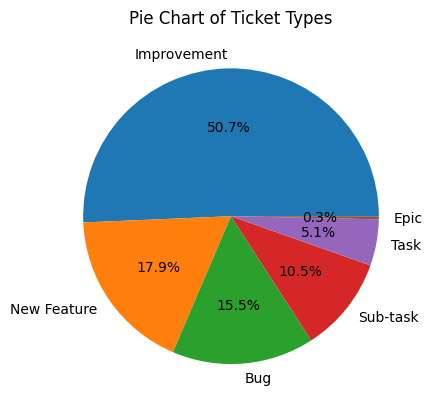

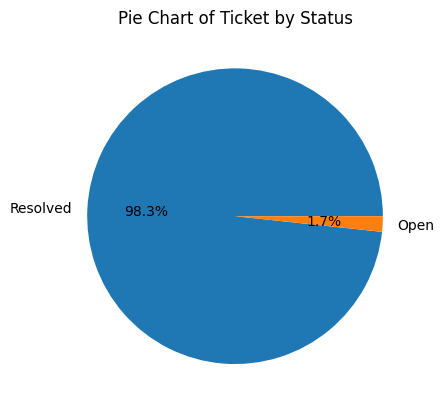

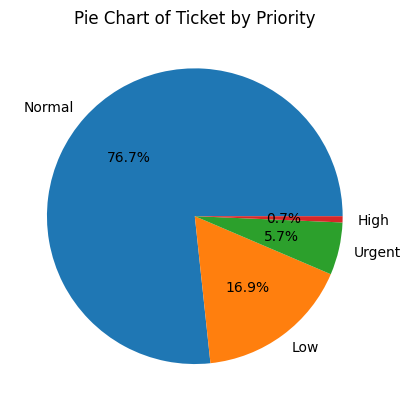

In [ ]:
show_pie(my_df=my_issues, my_field='issue_type', my_title="Pie Chart of Ticket Types")
show_pie(my_df=my_issues, my_field='status', my_title="Pie Chart of Ticket by Status")
show_pie(my_df=my_issues, my_field='priority', my_title="Pie Chart of Ticket by Priority")

### Find Out The Sample Size

This calculator computes the minimum number of necessary samples to meet the desired statistical constraints.

In [ ]:
confidence_level = 0.95
margin_of_error = 0.05
population_proportion = 0.5
population_size = 300

sample_size = calculate_sample_size(confidence_level, margin_of_error, population_proportion, population_size)
print(f"Required sample size: {sample_size}")

Required sample size: 168


In [ ]:
list_issue_key = my_issues.issue_key
sample_169_issues = random.choices(list_issue_key, k=169)
print(f'{len(sample_169_issues)} para inspeção manual')

169 para inspeção manual


### Cria um arquivo texto para cada issue

 Gera os arquivos .txt de cada issue contendo as informações (summary, type, status, description e comments) de cada issue.

In [ ]:
# Gera os arquivos .txt de cada issue
#my_dir_name = 'my_issues'
#total_of_issues = my_issues.shape[0]
#for index in tqdm.tqdm(my_issues.index, total=total_of_issues, desc='Analyzing issues'):
#  if my_issues.issue_key[index] in sample_169_issues:
#    create_new_file(filename=my_issues.issue_key[index], dir_name=my_dir_name, issue_type=my_issues.issue_type[index], summary=my_issues.summary[index], description=my_issues.description[index], status=my_issues.status[index], comments=my_issues.comments[index])

### Inspection of My Issues

Contem os arquivos textos com as informações básicas dos issues e os arquivos texto com o resultado da inspeção para cada issue analisado manualmente em busca de impacto arquitetural ou architectural issue.

In [ ]:
!unzip my_issues.zip -d my_analyze

Archive:  my_issues.zip
   creating: my_analyze/my_issues/
  inflating: my_analyze/my_issues/CASSANDRA-6809  
  inflating: my_analyze/my_issues/CASSANDRA-9664  
  inflating: my_analyze/my_issues/CASSANDRA-8671  
  inflating: my_analyze/my_issues/CASSANDRA-111  
  inflating: my_analyze/my_issues/CASSANDRA-8984  
  inflating: my_analyze/my_issues/CASSANDRA-2897  
  inflating: my_analyze/my_issues/CASSANDRA-1608  
  inflating: my_analyze/my_issues/CASSANDRA-12151  
  inflating: my_analyze/my_issues/CASSANDRA-5286  
  inflating: my_analyze/my_issues/CASSANDRA-9143  
  inflating: my_analyze/my_issues/CASSANDRA-3719  
  inflating: my_analyze/my_issues/CASSANDRA-2319  
  inflating: my_analyze/my_issues/CASSANDRA-16064  
  inflating: my_analyze/my_issues/CASSANDRA-16217  
  inflating: my_analyze/my_issues/CASSANDRA-9932  
  inflating: my_analyze/my_issues/CASSANDRA-17044  
  inflating: my_analyze/my_issues/CASSANDRA-5657  
  inflating: my_analyze/my_issues/CASSANDRA-11580  
  inflating: my_ana

In [ ]:
# Exemplo de conteúdo do issue 18123
!cat my_analyze/my_issues/CASSANDRA-18123

issue_type: Bug 
summary: Reuse of metadata collector can break key count calculation 
description: When flushing a memtable we currently pass a constructed {{MetadataCollector}} to the {{SSTableMultiWriter}} that is used for writing sstables. The latter may decide to split the data into multiple sstables (e.g. for separate disks or driven by compaction strategy) — if it does so, the cardinality estimation component in the reused {{MetadataCollector}} for each individual sstable contains the data for all of them.

As a result, when such sstables are compacted the estimation for the number of keys in the resulting sstables, which is used to determine the size of the bloom filter for the compaction result, is heavily overestimated.

This results in much bigger L1 bloom filters than they should be. One example (which came about during testing of the upcoming CEP-26, after insertion of 100GB data with 10% reads):
(current)
{code}
 		Bloom filter false positives: 22627369
 		Bloom filter fa

In [ ]:
!unzip my_inspection.zip -d my_analyze

Archive:  my_inspection.zip
   creating: my_analyze/my_inspection/
  inflating: my_analyze/my_inspection/CASSANDRA-17044.txt  
   creating: my_analyze/__MACOSX/
   creating: my_analyze/__MACOSX/my_inspection/
  inflating: my_analyze/__MACOSX/my_inspection/._CASSANDRA-17044.txt  
  inflating: my_analyze/my_inspection/CASSANDRA-1501.txt  
  inflating: my_analyze/__MACOSX/my_inspection/._CASSANDRA-1501.txt  
  inflating: my_analyze/my_inspection/CASSANDRA-5613.txt  
  inflating: my_analyze/__MACOSX/my_inspection/._CASSANDRA-5613.txt  
  inflating: my_analyze/my_inspection/CASSANDRA-5149.txt  
  inflating: my_analyze/__MACOSX/my_inspection/._CASSANDRA-5149.txt  
  inflating: my_analyze/my_inspection/CASSANDRA-16789.txt  
  inflating: my_analyze/__MACOSX/my_inspection/._CASSANDRA-16789.txt  
  inflating: my_analyze/my_inspection/CASSANDRA-14404.txt  
  inflating: my_analyze/__MACOSX/my_inspection/._CASSANDRA-14404.txt  
  inflating: my_analyze/my_inspection/CASSANDRA-14821.txt  
  inflating

In [ ]:
# Exemplo de resultado da inspeção do issue 18123
!cat my_analyze/my_inspection/CASSANDRA-18123.txt

Architectural Impact:

The described issue points to a specific architectural consideration within the Cassandra storage engine. When flushing a memtable to disk, a constructed MetadataCollector is used to gather metadata about the flushed data. This metadata collector is later passed to the SSTableMultiWriter responsible for writing the sstables to disk. The SSTableMultiWriter may decide to split the data into multiple sstables, either for separate disks or as driven by the compaction strategy.

The architectural impact of this issue is as follows:

Metadata Collection: The Cassandra architecture includes a metadata collection mechanism during the process of flushing memtables to sstables. This metadata includes cardinality estimations, which are used in various operations such as determining the size of bloom filters for compaction results.

SSTable Multi-Writer: The architecture includes the concept of an SSTableMultiWriter responsible for writing sstables to disk. The MetadataColle

In [ ]:
#!zip -r my_issues.zip my_issues

## Commits

In [ ]:
my_commits.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 288 entries, 0 to 287
Data columns (total 13 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   Unnamed: 0           288 non-null    int64 
 1   commits              288 non-null    object
 2   issues_ids           288 non-null    object
 3   data                 288 non-null    object
 4   msg                  288 non-null    object
 5   lines                288 non-null    int64 
 6   files                288 non-null    int64 
 7   critical_files       288 non-null    object
 8   keywords             288 non-null    object
 9   comments             288 non-null    object
 10  diff_commit          288 non-null    object
 11  modified_files       288 non-null    object
 12  dict_modified_files  288 non-null    object
dtypes: int64(3), object(10)
memory usage: 29.4+ KB


In [ ]:
my_commits.head(3)

,Unnamed: 0,commits,issues_ids,data,msg,lines,files,critical_files,keywords,comments,diff_commit,modified_files,dict_modified_files
0,0,907d92e21b8ce79e6a224933764e3b7215a94454,['CASSANDRA-65'],27/4/2009,replace BigInteger tokens with BigIntegerToken...,1090,31,"['ColumnFamilyStore.java', 'StorageService.java']","['files', 'test', 'TODO']",['\t \t //if( !isLoo...,"[{'ColumnFamilyStore.java': '@@ -43,6 +43,7 @@...","['ColumnFamilyStore.java', 'DBManager.java', '...","['@@ -43,6 +43,7 @@ import org.apache.log4j.Lo..."
1,26,f2da00fb0f2c92351b136ac13082b278c534c6ab,['CASSANDRA-139'],15/7/2009,thrift changes to remove : api.\nuse ColumnPat...,7987,65,"['DatabaseDescriptor.java', 'ColumnFamilyStore...","['API', 'TODO', 'TODO', 'TODO']","[' * Thrift API has changed a _lot_:', "" ...","[{'DatabaseDescriptor.java': '@@ -71,7 +71,7 @...","['CHANGES.txt', 'cassandra.thrift', 'BatchMuta...","['@@ -1,10 +1,14 @@\n 0.4 dev\n- * Added colum..."
2,27,986cee6806c5798c1c826d965ecadad0cfc70cc7,['CASSANDRA-185'],21/7/2009,change String column names to byte[] to allow ...,2582,84,"['DatabaseDescriptor.java', 'ColumnFamilyStore...","['TODO', 'confusing', 'TODO', 'TODO', 'fix']",[' // TODO duplicating data b/t tablemetada...,"[{'DatabaseDescriptor.java': '@@ -24,6 +24,9 @...","['storage-conf.xml', 'cassandra.thrift', 'Cass...","['@@ -49,13 +49,21 @@\n disab..."


### Describe statistics

In [ ]:
round(my_commits.describe(), 2)

,Unnamed: 0,lines,files
count,288.00,288.00,288.00
mean,924.15,5112.86,76.09
std,387.78,11625.61,86.57
min,0.00,879.00,22.00
25%,636.75,1451.75,32.00
50%,945.00,2491.50,46.00
75%,1265.50,3881.75,71.00
max,1495.00,107283.00,645.00


<Axes: >

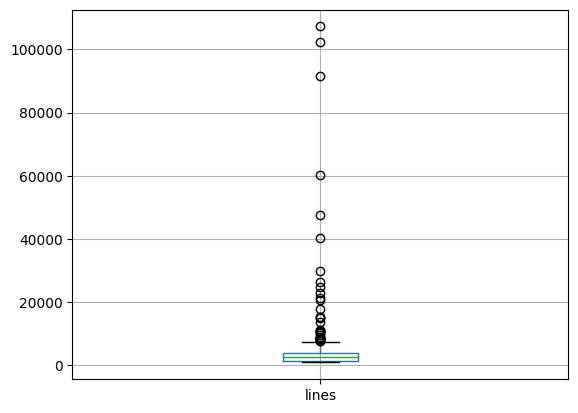

In [ ]:
my_commits.boxplot(column='lines')

<Axes: >

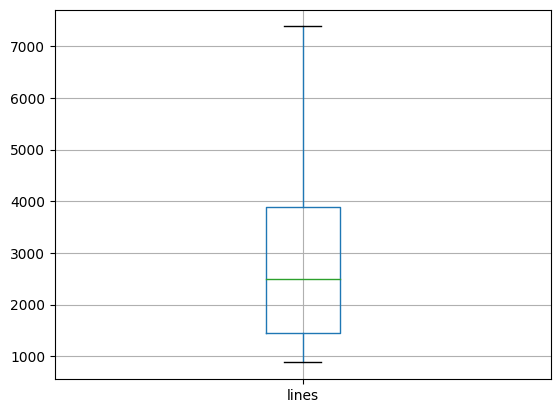

In [ ]:
my_commits.boxplot(column='lines', showfliers=False)

<Axes: >

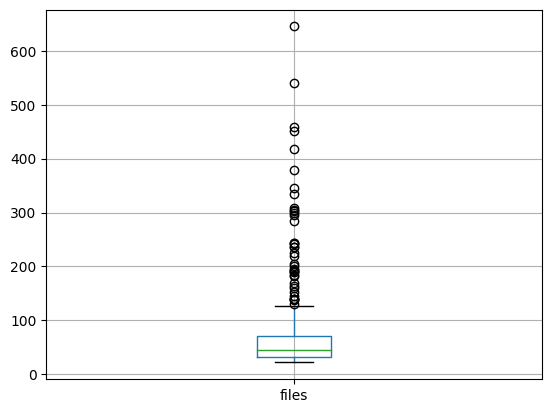

In [ ]:
my_commits.boxplot(column='files')

<Axes: >

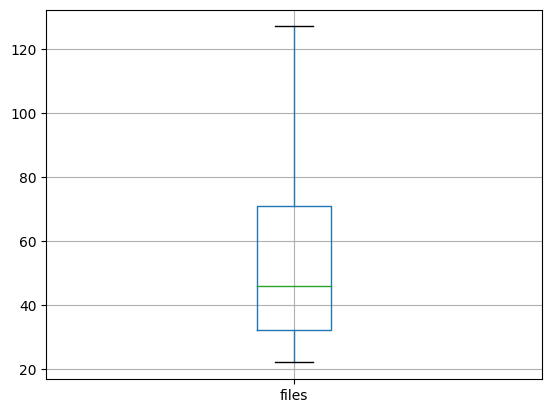

In [ ]:
my_commits.boxplot(column='files', showfliers=False)

### Keywords

In [ ]:
for each_list in my_commits.keywords:
  print(each_list)

['files', 'test', 'TODO']
['API', 'TODO', 'TODO', 'TODO']
['TODO', 'confusing', 'TODO', 'TODO', 'fix']
['implementation', 'implementation', 'exception', 'exception', 'exception', 'exception', 'exception', 'implementation', 'implementation', 'implementation', 'implementation', 'interface', 'documentation', 'interface', 'interface', 'implementation', 'interface', 'documentation', 'interface', 'fix', 'implementation', 'interface', 'implementation', 'throughput', 'throughput', 'TODO', 'confusing', 'implementation', 'TODO', 'fix', 'TODO', 'TODO', 'fix', 'TODO', 'files', 'files', 'files', 'files', 'files', 'files', 'files', 'ugly', 'files', 'files', 'rename', 'files', 'clean', 'update', 'update', 'files', 'files', 'files', 'files', 'files', 'files', 'files', 'files', 'files', 'clean', 'TODO', 'comment', 'files', 'files', 'exception', 'files', 'files', 'files', 'files', 'test', 'TODO', 'clean', 'files', 'exception', 'files', 'TODO', 'latency', 'test', 'test', 'output', 'fix', 'header', 'heade

### Critical Files

In [ ]:
for each in my_commits.critical_files:
  print(each)

['ColumnFamilyStore.java', 'StorageService.java']
['DatabaseDescriptor.java', 'ColumnFamilyStore.java']
['DatabaseDescriptor.java', 'ColumnFamilyStore.java', 'SSTableReader.java', 'CassandraDaemon.java']
['DatabaseDescriptor.java', 'ColumnFamilyStore.java', 'SSTableReader.java', 'MessagingService.java', 'StorageProxy.java', 'StorageService.java']
['StorageService.java']
['DatabaseDescriptor.java', 'CompactionManager.java', 'StorageProxy.java', 'StorageService.java', 'NodeProbe.java']
['ColumnFamilyStore.java', 'CompactionManager.java', 'SSTableReader.java']
['ColumnFamilyStore.java', 'StorageProxy.java', 'StorageService.java', 'NodeProbe.java']
['DatabaseDescriptor.java', 'StorageProxy.java', 'StorageService.java', 'NodeProbe.java']
['DatabaseDescriptor.java', 'StorageService.java']
['ColumnFamilyStore.java', 'CompactionManager.java', 'SSTableReader.java', 'StorageProxy.java', 'StorageService.java', 'NodeProbe.java']
['StorageProxy.java', 'StorageService.java']
['DatabaseDescriptor.jav

### Modified_files

In [ ]:
for each in my_commits.modified_files:
  print(each)

['ColumnFamilyStore.java', 'DBManager.java', 'FileStruct.java', 'SystemTable.java', 'BigIntegerToken.java', 'BootStrapper.java', 'IPartitioner.java', 'LeaveJoinProtocolHelper.java', 'LeaveJoinProtocolImpl.java', 'OrderPreservingHashPartitioner.java', 'OrderPreservingPartitioner.java', 'RandomPartitioner.java', 'Range.java', 'StringToken.java', 'Token.java', 'SSTable.java', 'AbstractStrategy.java', 'IReplicaPlacementStrategy.java', 'RackAwareStrategy.java', 'RackUnawareStrategy.java', 'TokenMetadata.java', 'StorageLoadBalancer.java', 'StorageService.java', 'StorageServiceMBean.java', 'TokenUpdateVerbHandler.java', 'MembershipCleanerVerbHandler.java', 'TokenUpdateVerbHandler.java', 'TokenUpdater.java', 'FastObjectHash.java', 'SystemTableTest.java', 'RangeTest.java']
['CHANGES.txt', 'cassandra.thrift', 'BatchMutation.java', 'BatchMutationSuper.java', 'Cassandra.java', 'Column.java', 'ColumnParent.java', 'ColumnPath.java', 'ColumnPathOrParent.java', 'CqlResult.java', 'CqlResult_t.java', 'I